In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score, validation_curve
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from datetime import datetime as dt
from datacleaner import autoclean
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
np.random.seed(0) 

1. Load data

In [136]:
salaries = pd.read_csv('data/salary.csv')
salaries = salaries.sample(frac=0.05, random_state=0)
salaries['salary'] = np.where(salaries['salary'] == ' <=50K', 0, 1)

In [21]:
diabetes = pd.read_csv('data/diabetes.csv')

2. Data Preprocessing

In [22]:
def drop_duplicate_rows(df):
    return df.drop_duplicates(keep='first')

def normalize_features(df):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
    return df_scaled

def split_dataset(df, target_col):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)
    X_train, X_test = train_df.drop(target_col, axis=1), test_df.drop(target_col, axis=1)
    y_train, y_test = train_df[target_col], test_df[target_col]
    return X_train, y_train, X_test, y_test

In [138]:
salaries = autoclean(salaries)
salaries = drop_duplicate_rows(salaries)
salaries = normalize_features(salaries)
salaries_X_train, salaries_y_train,  salaries_X_test, salaries_y_test, = split_dataset(salaries, 'salary')
salaries_X = np.concatenate((salaries_X_train, salaries_X_test))
salaries_y = np.concatenate((salaries_y_train, salaries_y_test))

diabetes = autoclean(diabetes)
diabetes = drop_duplicate_rows(diabetes)
diabetes = normalize_features(diabetes)
diabetes_X_train, diabetes_y_train,  diabetes_X_test, diabetes_y_test, = split_dataset(diabetes, 'Outcome')
diabetes_X = np.concatenate((diabetes_X_train, diabetes_X_test))
diabetes_y = np.concatenate((diabetes_y_train, diabetes_y_test))

3. Utility Functions

In [103]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def kmeans_clustering(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(data)
    return labels

def em_clustering(data, n_components):
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(data)
    labels = gmm.predict(data)
    return labels


In [289]:
from sklearn.metrics import silhouette_score

def plot_kmeans_clustering(data):
    #inertias = []
    scores = []
    best_score = -1
    best_k = -1
    best_model = None
    best_labels = None
    #best_inertia = float('inf')
#     for k in range(2, 11):
#         model = KMeans(n_clusters=k, random_state=42)
#         model.fit(data)
#         inertia = model.inertia_
#         inertias.append(inertia)
#         if inertia < best_inertia:
#             best_inertia = inertia
#             best_k = k
    for k in range(2, 11):
        model = KMeans(n_clusters=k, random_state=42)
        cluster_labels = model.fit_predict(data)
        score = silhouette_score(data, cluster_labels)
        scores.append(score)
        if score > best_score:
            best_score = score
            best_k = k
            best_model = model
            best_labels = best_model.predict(data)
    plt.plot(range(2, 11), scores)
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('K-Means Clustering')
    plt.show()
    if best_model is not None:
        fig, ax = plt.subplots()
        for i in range(best_k):
            cluster_data = data[best_labels == i]
            ax.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i+1}')
        ax.legend()
        plt.title(f'K Means Clustering with {best_k} clusters')
        plt.show()
    return best_k, best_score

def plot_em_clustering(data):
    scores = []
    best_score = -1
    best_k = -1
    best_model = None
    best_labels = None
    for k in range(2, 11):
        model = GaussianMixture(n_components=k, random_state=42)
        cluster_labels = model.fit_predict(data)
        score = silhouette_score(data, cluster_labels)
        scores.append(score)
        if score > best_score:
            best_score = score
            best_k = k
            best_model = model
            best_labels = best_model.predict(data)
    plt.plot(range(2, 11), scores)
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('EM Clustering')
    plt.show()
    if best_model is not None:
        fig, ax = plt.subplots()
        for i in range(best_k):
            cluster_data = data[best_labels == i]
            ax.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i+1}')
        ax.legend()
        plt.title(f'EM Clustering with {best_k} clusters')
        plt.show()
    return best_k, best_score


In [54]:
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# def pca(data, n_components):
#     pca = PCA(n_components=n_components)
#     transformed_data = pca.fit_transform(data)
#     return transformed_data

def pca(data, n):
    pca = PCA(n_components=n)
    pca_transform_X = pca.fit_transform(data)
    return pca, pca_transform_X

def scree_plot_pca(pca):
    PC_values = np.arange(pca.n_components_) + 1
    plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
    plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'o-', linewidth=2, color='green')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.legend(['Individual', 'Cumulative'])
    plt.show()

def ica(data, n_components):
    ica = FastICA(n_components=n_components)
    transformed_X = ica.fit_transform(data)
    return transformed_X

def randomized_projection(data, n_components):
    rp = GaussianRandomProjection(n_components=n_components)
    transformed_X = rp.fit_transform(data)
    return transformed_X

def feature_selection(X,y, n_features):
    fs = SelectKBest(mutual_info_classif, k=n_features)
    transformed_X = fs.fit_transform(X,y)
    return transformed_X

In [210]:
from sklearn.tree import DecisionTreeClassifier

In [265]:
def get_classification_results(X_train, y_train, X_test, n_components, reduction_type = 'pca', classification_type = 'kmeans'):
    pca_model_train, transformed_X_train, transformed_X_test = None, None, None
    if reduction_type == 'pca':
        pca_model_train, transformed_X_train = pca(X_train, n_components)
        transformed_X_test = pca_model_train.transform(X_test)
        #pca_model_test, transformed_X_test = pca(X_test, n_components)
    elif reduction_type =='ica':
        ica = FastICA(n_components=n_components)
        transformed_X_train  = ica.fit_transform(X_train)
        transformed_X_test = ica.transform(X_test)
        #transformed_X_test = ica(X_test, n_components)
    elif reduction_type =='rp':
        rp = GaussianRandomProjection(n_components=n_components)
        transformed_X_train = rp.fit_transform(X_train)
        transformed_X_test = rp.transform(X_test)
        #transformed_X_test = randomized_projection(X_test, n_components)
    elif reduction_type == 'fs':
        fs = SelectKBest(mutual_info_classif, k=n_components)
        transformed_X_train = fs.fit_transform(X_train,y_train) 
        transformed_X_test = fs.transform(X_test)
        #feature_selection(X_trainy_train , n_components)
        #transformed_X_test = feature_selection(X_test, y_test , n_components)
#print(transformed_X_train.shape)
    if classification_type == 'kmeans':
        y_pred = kmeans_clustering(transformed_X_train, 2)
    elif classification_type == 'em':
        y_pred = em_clustering(transformed_X_train, 2)
    elif classification_type == 'dt':
        dt_model = DecisionTreeClassifier()
        dt_model.fit(transformed_X_train, y_train)
        y_pred = dt_model.predict(transformed_X_test)
    
    return y_pred


def get_accuracy_score_across_components(X_test, y_test, max_n, X_train, y_train, reduction_type = 'pca', classification_type = 'kmeans'):
    min_n = 2
    accuracy_scores = []
    for n in range(2, max_n+1):
#         print(f'Getting Labels for {clustering_type}, n_components = {n} for {reduction_type}')
#         print(y_test.shape)
        y_pred = get_classification_results(X_train, y_train, X_test, n, reduction_type, classification_type)
       # print(y_pred.shape)
#         print(y_pred)
#         print(f'Getting Accuracy Score for {clustering_type}, n_components = {n} for {reduction_type}')
        score = accuracy_score(y_test, y_pred)
        accuracy_scores.append(score)
    return accuracy_scores


def plot_accuracy_scores(X_train, y_train, X_test, y_test, ctype = 'kmeans'):
    colors = ['blue', 'red', 'green', 'orange']
    labels = ['pca', 'ica', 'rp', 'fs']
    fig, ax = plt.subplots()
    #for i in range(len(n_components)):
    pca_accuracy = get_accuracy_score_across_components(X_test, y_test, max_n= X_train.shape[1], X_train=X_train, y_train=y_train,
                                                         reduction_type='pca', classification_type=ctype)
    ica_accuracy = get_accuracy_score_across_components(X_test, y_test, max_n= X_train.shape[1], X_train=X_train, y_train=y_train,
                                                         reduction_type='ica', classification_type=ctype)
    rp_accuracy = get_accuracy_score_across_components(X_test, y_test, max_n= X_train.shape[1], X_train=X_train, y_train=y_train,
                                                        reduction_type='rp', classification_type=ctype)
    fs_accuracy = get_accuracy_score_across_components(X_test, y_test, max_n= X_train.shape[1], X_train=X_train, y_train=y_train,
                                                        reduction_type='fs', classification_type=ctype)
    ax.plot(range(2, X_train.shape[1] + 1), pca_accuracy, '-o', color=colors[0], label=labels[0])
    ax.plot(range(2, X_train.shape[1] + 1), ica_accuracy, '-o', color=colors[1], label=labels[1])
    ax.plot(range(2, X_train.shape[1] + 1), rp_accuracy, '-o', color=colors[2], label=labels[2])
    ax.plot(range(2, X_train.shape[1] + 1), fs_accuracy, '-o', color=colors[3], label=labels[3])
    ax.set_title(f'Accuracy Scores for {ctype}')
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Accuracy Score')
    ax.legend()
    plt.show()
    best_pca_n = pca_accuracy.index(max(pca_accuracy))
    best_ica_n = ica_accuracy.index(max(ica_accuracy))
    best_rp_n = rp_accuracy.index(max(rp_accuracy))
    best_fs_n = fs_accuracy.index(max(fs_accuracy))
        
    return best_pca_n, best_ica_n, best_rp_n, best_fs_n

            

4. Salaries Data

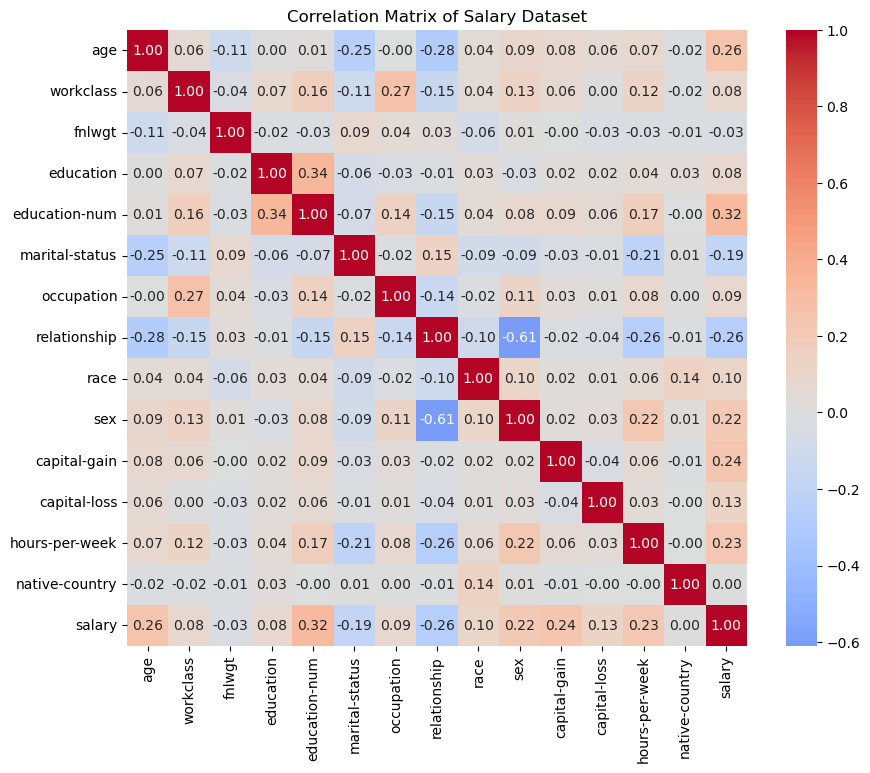

In [207]:
import seaborn as sns
import pandas as pd
import scipy.stats

corr = salaries.corr()

# plot the correlation matrix using seaborn
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=True, fmt='.2f')

ax.set_title('Correlation Matrix of Salary Dataset')

# show the plot
plt.show()

# # calculate the p-values for each pair of variables
# p_values = np.zeros_like(corr)
# for i in range(len(corr)):
#     for j in range(len(corr)):
#         if i != j:
#             _, p_values[i, j] = scipy.stats.pearsonr(salaries.iloc[:, i], salaries.iloc[:, j])

# # add a mask to show the statistically significant correlations
# mask = np.ones_like(corr, dtype=bool)
# mask[np.tril_indices_from(mask)] = False
# mask[p_values > 0.05] = False

# # plot the masked heatmap
# sns.heatmap(corr, cmap='coolwarm', center=0, annot=True, fmt='.2f', mask=mask)



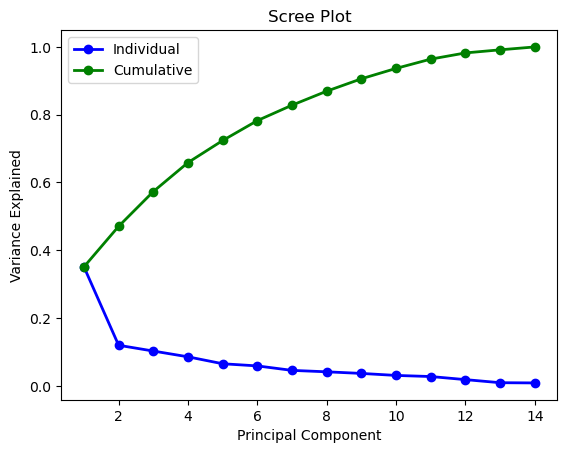

In [140]:
salaries_pca, salaries_pca_X = pca(salaries_X, salaries_X.shape[1])
scree_plot_pca(salaries_pca)

In [199]:
from scipy.stats import kurtosis, shapiro
import numpy as np

# kurt = kurtosis(salaries_X, axis=0)
# print(f'kurtosis:{kurt}')

# if np.allclose(kurt, 3):
#     print("Data has a Gaussian distribution")
# else:
#     print("Data does not have a Gaussian distribution")

stat, p = shapiro(salaries_X)
print(f'shapiro p value:{p}')
if p > 0.05:
    print('Data is normally distributed')
else:
    print('Data is not normally distributed')

shapiro p value:0.0
Data is not normally distributed


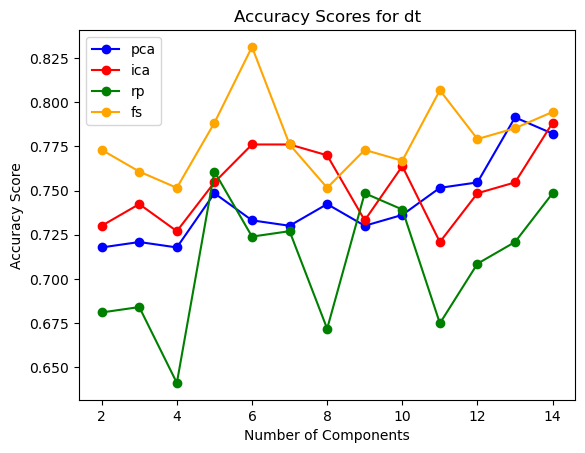

(11, 12, 3, 4)

In [268]:
#def plot_accuracy_scores(X_train, y_train, X_test, y_test, ctype = 'kmeans'):
import random
random.seed(123)

plot_accuracy_scores(salaries_X_train, salaries_y_train, salaries_X_test, salaries_y_test, ctype = 'dt')

In [257]:
salaries_optimal_n_pca, salaries_optimal_n_ica, salaries_optimal_n_rp, salaries_optimal_n_fs  = 5, 6, 5, 6
salaries_pca, salaries_transformed_X = pca(salaries_X, salaries_optimal_n_pca)
salaries_ica_X = ica(salaries_X, salaries_optimal_n_ica)
salaries_rp_X = randomized_projection(salaries_X, salaries_optimal_n_rp)
salaries_fs_X = feature_selection(salaries_X, salaries_y, salaries_optimal_n_fs)

In [258]:
salaries_data_mapping = {'untransformed': salaries_X, 'pca': salaries_transformed_X, 'ica': salaries_ica_X, 'rp': salaries_rp_X, 'fs':salaries_fs_X }

Clustering untransformed data...


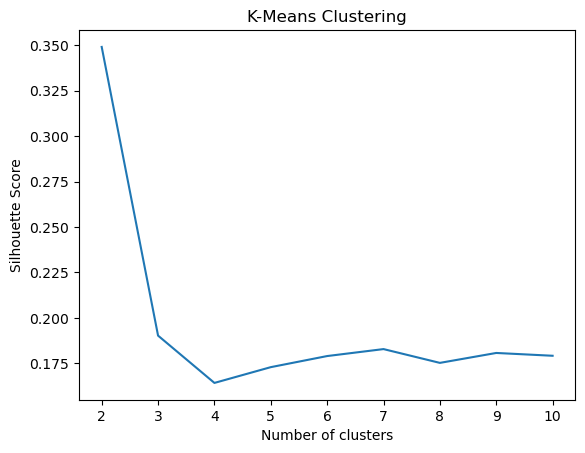

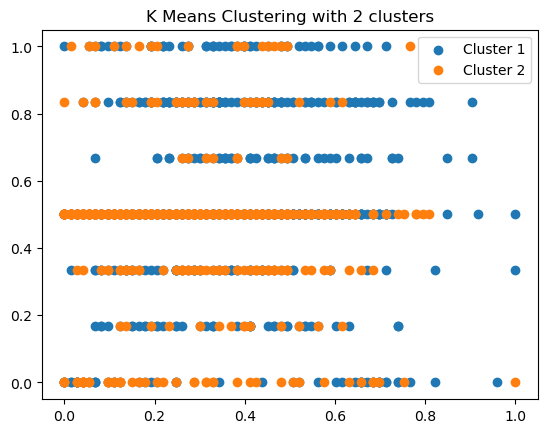

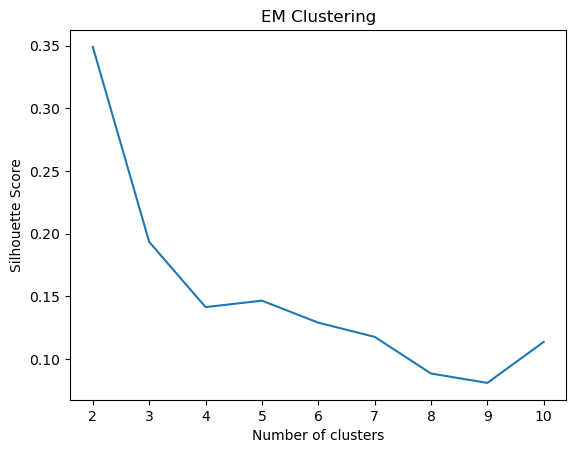

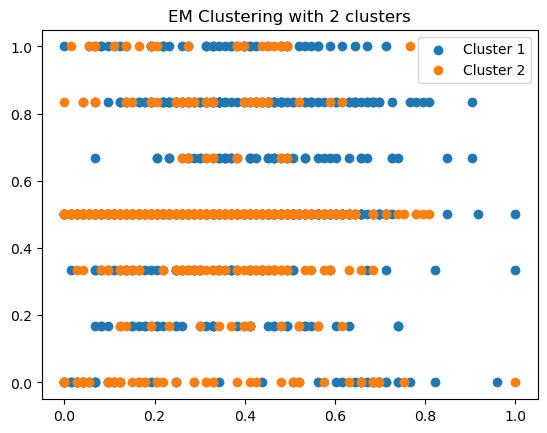

Clustering pca data...


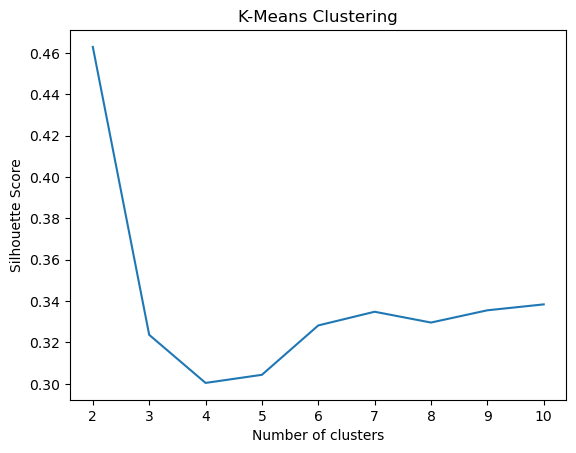

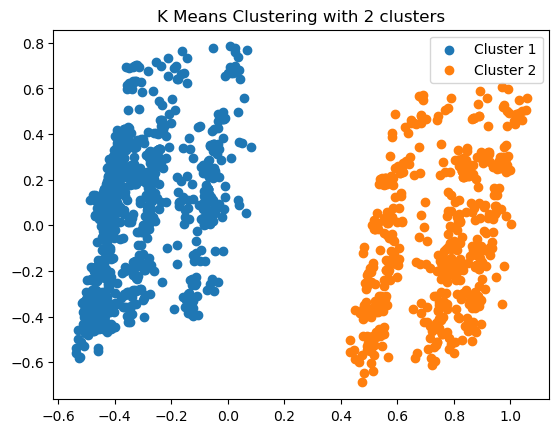

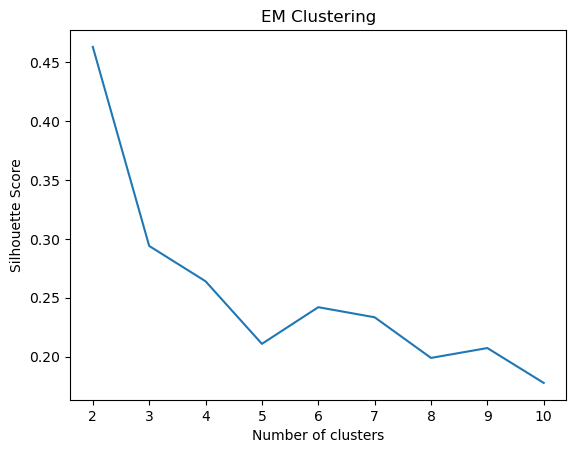

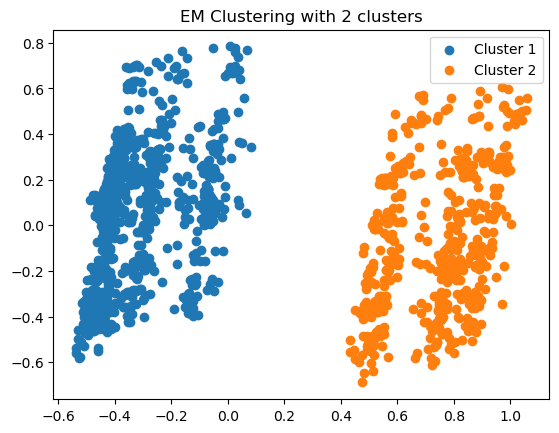

Clustering ica data...


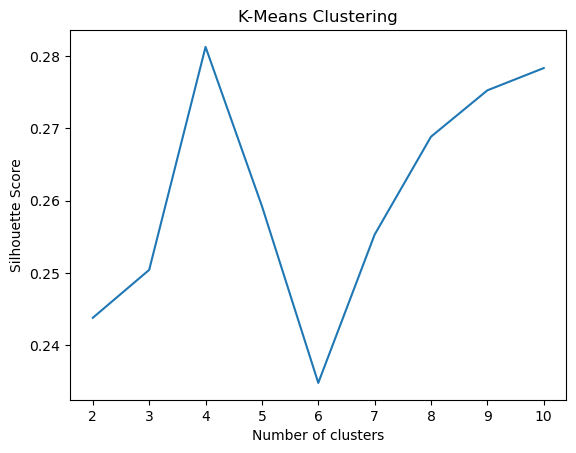

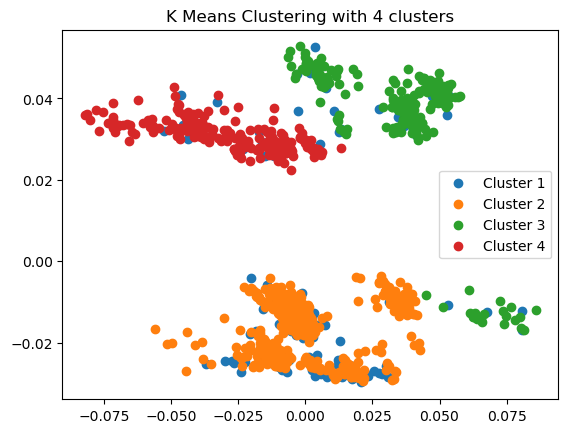

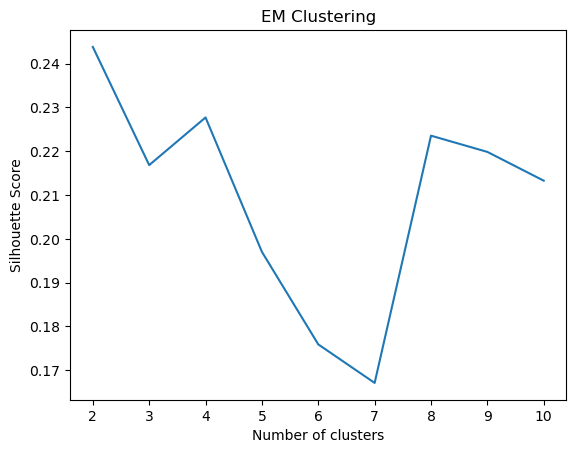

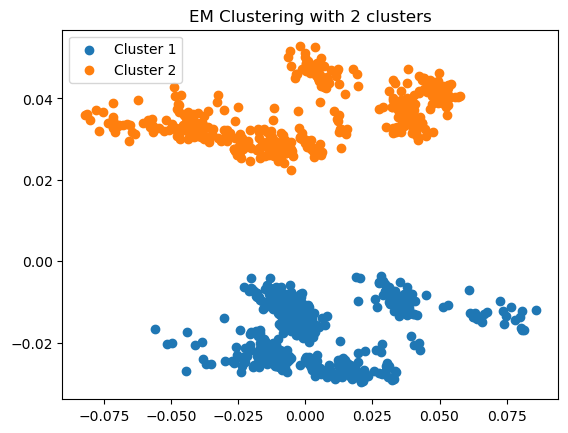

Clustering rp data...


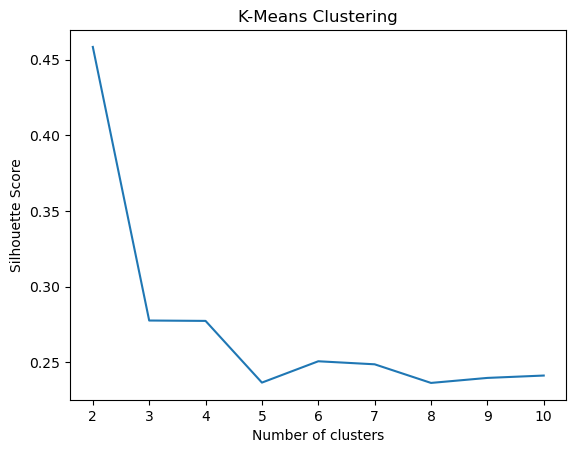

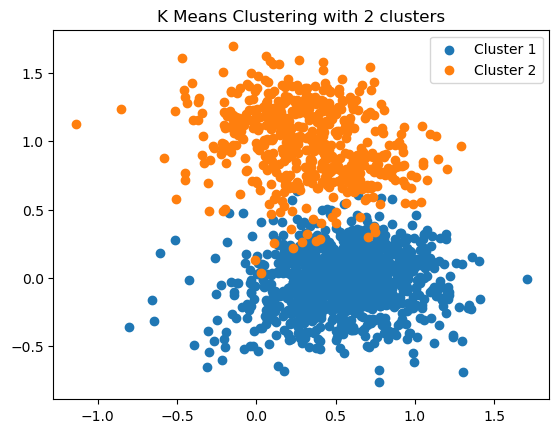

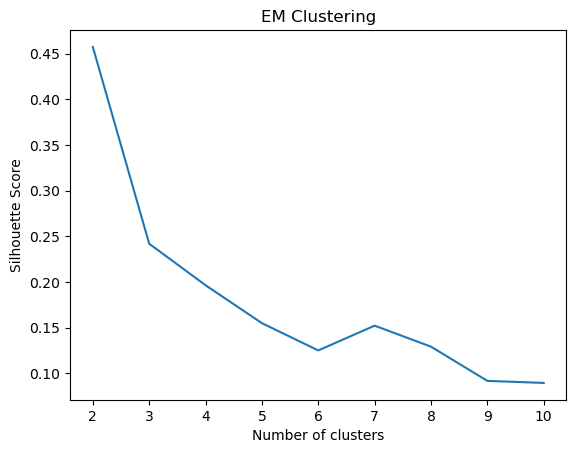

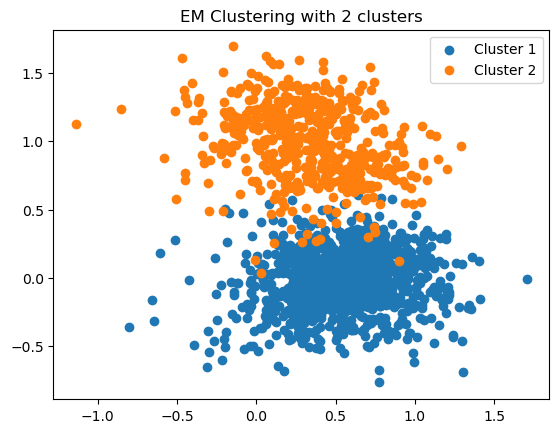

Clustering fs data...


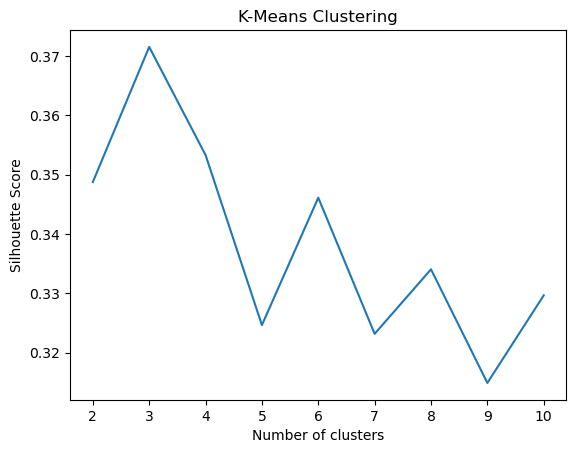

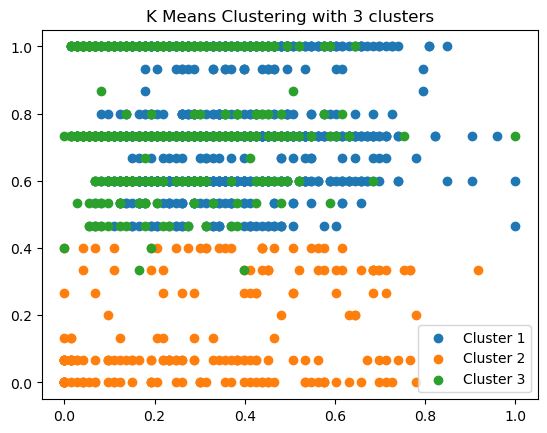

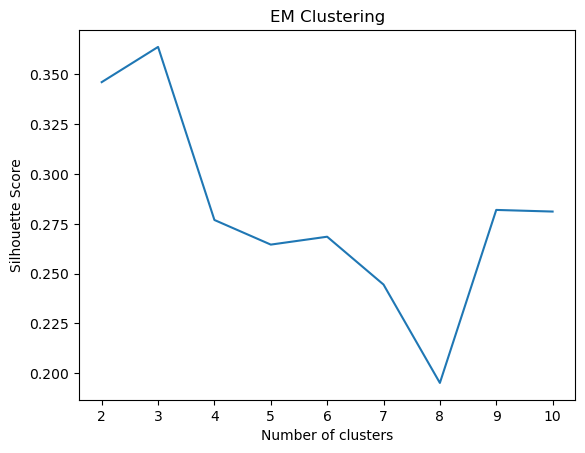

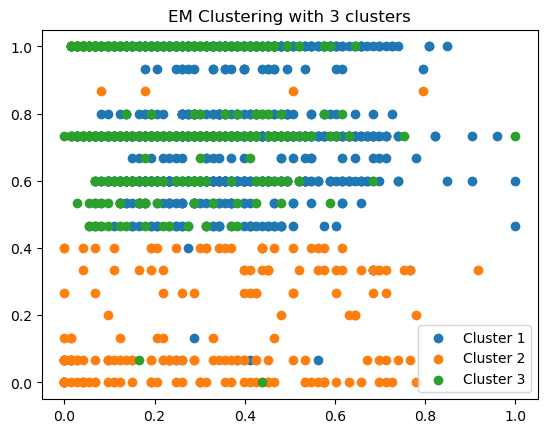

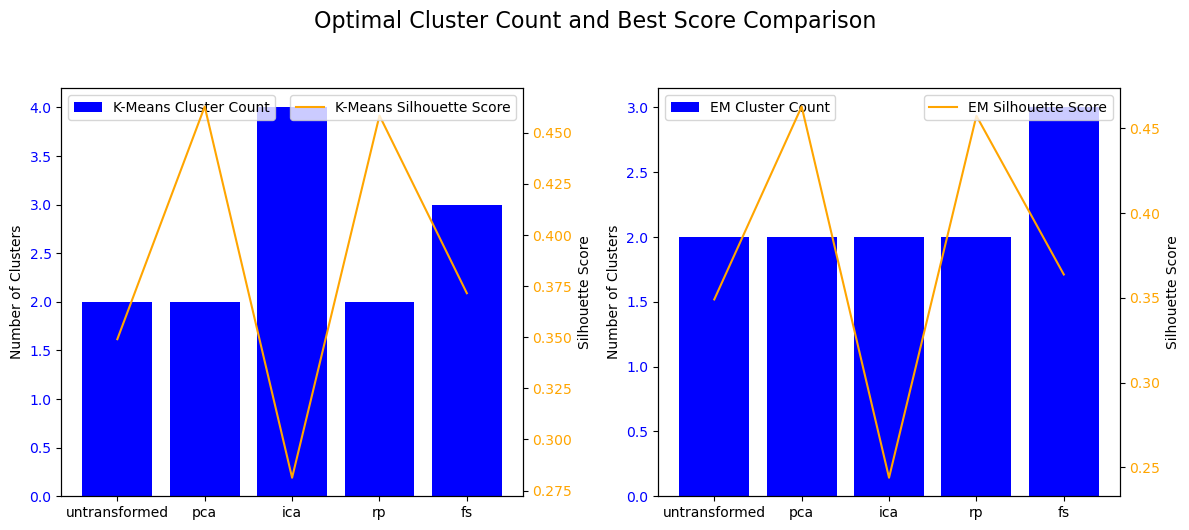

In [301]:
cluster_results = {}
for name, data in salaries_data_mapping.items():
    print(f'Clustering {name} data...')
    kmeans_k, kmeans_score = plot_kmeans_clustering(data)
    em_k, em_score = plot_em_clustering(data)
    cluster_results[name] = {'kmeans_k': kmeans_k, 'kmeans_score': kmeans_score, 'em_k': em_k, 'em_score': em_score}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

x_labels = list(salaries_data_mapping.keys())
kmeans_ks = [cluster_results[name]['kmeans_k'] for name in x_labels]
kmeans_scores = [cluster_results[name]['kmeans_score'] for name in x_labels]
ax1.bar(x_labels, kmeans_ks, label='K-Means Cluster Count', color='blue')
ax1.set_ylabel('Number of Clusters')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

ax1_scores = ax1.twinx()
ax1_scores.plot(x_labels, kmeans_scores, label='K-Means Silhouette Score', color='orange')
ax1_scores.set_ylabel('Silhouette Score')
ax1_scores.tick_params(axis='y', labelcolor='orange')
ax1_scores.legend(loc='upper right')

em_ks = [cluster_results[name]['em_k'] for name in x_labels]
em_scores = [cluster_results[name]['em_score'] for name in x_labels]
ax2.bar(x_labels, em_ks, label='EM Cluster Count', color='blue')
ax2.set_ylabel('Number of Clusters')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc='upper left')

ax2_scores = ax2.twinx()
ax2_scores.plot(x_labels, em_scores, label='EM Silhouette Score', color='orange')
ax2_scores.set_ylabel('Silhouette Score')
ax2_scores.tick_params(axis='y', labelcolor='orange')
ax2_scores.legend(loc='upper right')

plt.suptitle('Optimal Cluster Count and Best Score Comparison', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


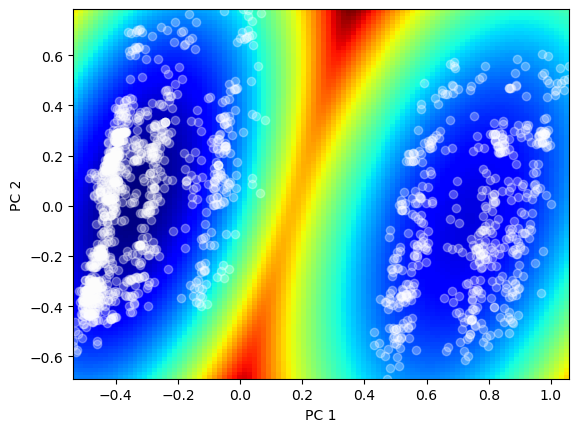

In [296]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

pca = PCA(n_components=2)
salaries_X_pca = pca.fit_transform(salaries_X)

gmm = GaussianMixture(n_components=2).fit(salaries_X_pca)

fig, ax = plt.subplots()
x, y = np.mgrid[salaries_X_pca[:,0].min():salaries_X_pca[:,0].max():100j, salaries_X_pca[:,1].min():salaries_X_pca[:,1].max():100j]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y
dens = -gmm.score_samples(pos.reshape(-1, 2))
dens = dens.reshape(100, 100)
ax.imshow(dens.T, origin='lower', cmap='jet', aspect='auto', extent=[salaries_X_pca[:,0].min(), salaries_X_pca[:,0].max(), salaries_X_pca[:,1].min(), salaries_X_pca[:,1].max()])
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.scatter(salaries_X_pca[:,0], salaries_X_pca[:,1], alpha=0.3, color='white')




# kde = KernelDensity(kernel='gaussian', bandwidth=5000).fit(salaries_X.reshape(-1, 1))
# x, y = np.mgrid[salaries_X[:,0].min():salaries_X[:,0].max():100j, salaries_X[:,1].min():salaries_X[:,1].max():100j]
# pos = np.empty(x.shape + (2,))
# pos[:, :, 0] = x
# pos[:, :, 1] = y
# dens = np.exp(kde.score_samples(pos.reshape(-1, 2)))
# dens = dens.reshape(100, 100)

# fig, ax = plt.subplots()
# ax.imshow(dens.T, origin='lower', cmap='jet', aspect='auto', extent=[salaries_X[:,0].min(), salaries_X[:,0].max(), salaries_X[:,1].min(), salaries_X[:,1].max()])
# ax.set_xlabel('Salary 1')
# ax.set_ylabel('Salary 2')
# plt.show()


# fig, ax = plt.subplots()
# ax.imshow(dens.T, origin='lower', cmap='jet', aspect='auto', extent=[salaries_X[:,0].min(), salaries_X[:,0].max(), salaries_X[:,1].min(), salaries_X[:,1].max()])
# ax.contour(x, y, multivariate_normal(mean=np.mean(salaries_X, axis=0), cov=np.cov(salaries_X.T)).pdf(pos), colors='white', linewidths=3)
# ax.set_xlabel('Salary 1')
# ax.set_ylabel('Salary 2')
# plt.show()

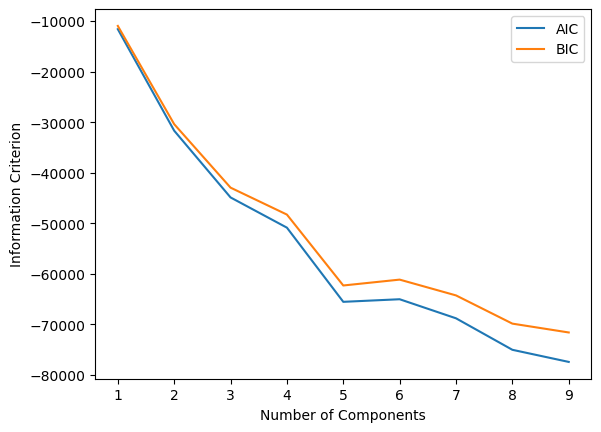

In [297]:
n_components_range = range(1, 10)
models = [GaussianMixture(n_components=n, covariance_type='full', random_state=0).fit(salaries_X) for n in n_components_range]

# Compute AIC and BIC for each model
AIC = [model.aic(salaries_X) for model in models]
BIC = [model.bic(salaries_X) for model in models]

# Plot AIC and BIC as a function of number of components
plt.plot(n_components_range, AIC, label='AIC')
plt.plot(n_components_range, BIC, label='BIC')
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Information Criterion')
plt.show()



In [260]:
# salaries_transformed_X
# salaries_ica
# salaries_randomized_projection 
# salaries_feature_selection 

#kmeans
kmeans_cluster_label = kmeans_clustering(salaries_X,2)
pca_kmeans_cluster_label = kmeans_clustering(salaries_transformed_X,2)
ica_kmeans_cluster_label = kmeans_clustering(salaries_ica_X,4)
rp_kmeans_cluster_label = kmeans_clustering(salaries_rp_X,2)
fs_kmeans_cluster_label = kmeans_clustering(salaries_fs_X,3)

salaries_X_kmeans = np.column_stack((salaries_X, kmeans_cluster_label))
salaries_transformed_X_kmeans = np.column_stack((salaries_transformed_X, pca_kmeans_cluster_label))
salaries_ica_X_kmeans = np.column_stack((salaries_ica_X, ica_kmeans_cluster_label))
salaries_rp_X_kmeans = np.column_stack((salaries_rp_X, rp_kmeans_cluster_label))
salaries_fs_X_kmeans = np.column_stack((salaries_fs_X, fs_kmeans_cluster_label))


#em
em_cluster_label = em_clustering(salaries_X,2)
pca_em_cluster_label = em_clustering(salaries_transformed_X,2)
ica_em_cluster_label = em_clustering(salaries_ica_X,2)
rp_em_cluster_label = em_clustering(salaries_rp_X,2)
fs_em_cluster_label = em_clustering(salaries_fs_X,3)


salaries_X_em = np.column_stack((salaries_X, em_cluster_label))
salaries_transformed_X_em = np.column_stack((salaries_transformed_X, pca_em_cluster_label))
salaries_ica_X_em = np.column_stack((salaries_ica_X, ica_em_cluster_label))
salaries_rp_X_em = np.column_stack((salaries_rp_X, rp_em_cluster_label))
salaries_fs_X_em = np.column_stack((salaries_fs_X, fs_em_cluster_label))


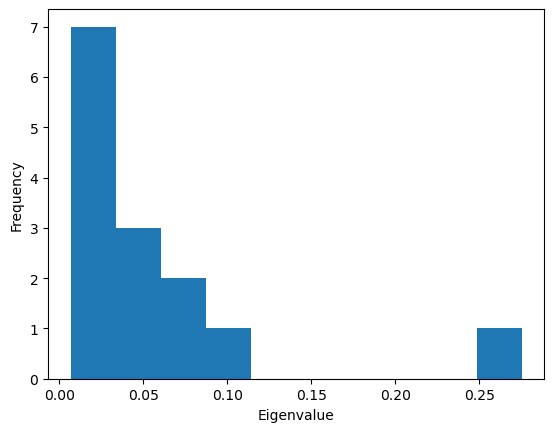

In [420]:
pca = PCA()

# fit PCA to data
pca.fit(salaries_X)

# get eigenvalues (variances explained by each component)
eigenvalues = pca.explained_variance_

# plot distribution of eigenvalues
plt.hist(eigenvalues, bins=10)
plt.xlabel('Eigenvalue')
plt.ylabel('Frequency')
plt.show()

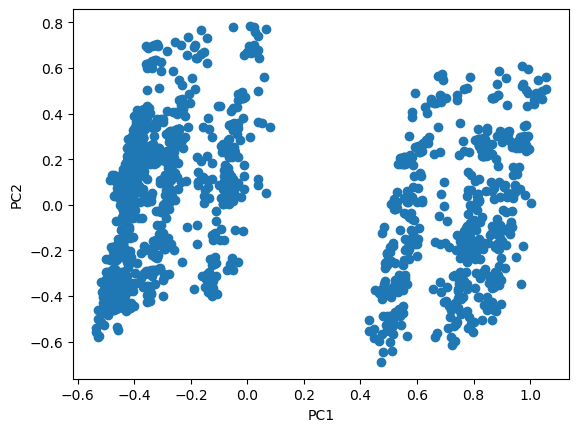

In [385]:
# plot the first two principal components
plt.scatter(salaries_transformed_X[:, 0], salaries_transformed_X[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

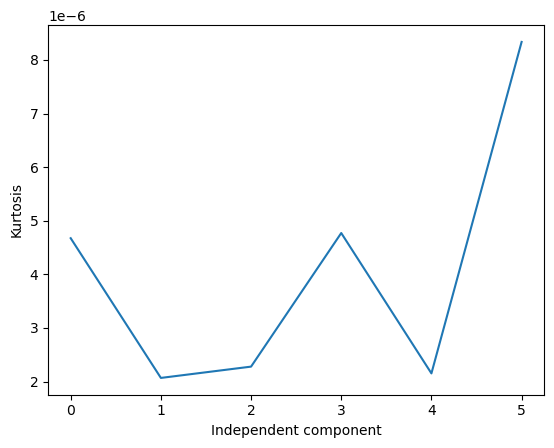

In [386]:
# calculate kurtosis of independent components
kurtosis = np.abs(np.asarray([np.mean((3 - 3 / (1 + x ** 4))) for x in salaries_ica_X.T]))

# plot kurtosis of independent components
plt.plot(kurtosis)
plt.xlabel('Independent component')
plt.ylabel('Kurtosis')
plt.show()

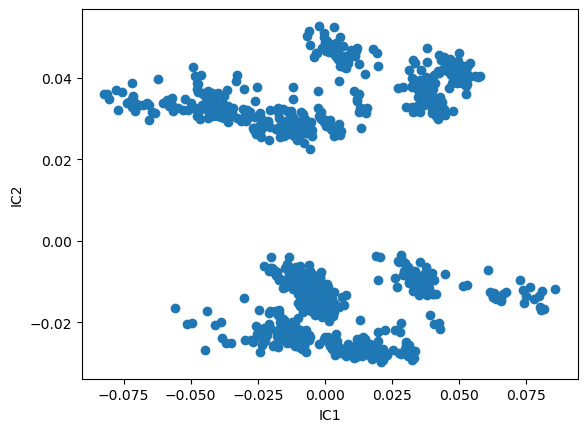

In [388]:
# transform data into independent component space
# plot the first two independent components
plt.scatter(salaries_ica_X[:, 0], salaries_ica_X[:, 1])
plt.xlabel('IC1')
plt.ylabel('IC2')
plt.show()

In [402]:
from sklearn.random_projection import GaussianRandomProjection

# create random projection model
rp = GaussianRandomProjection(n_components = 5)

# fit random projection to data
rp.fit(salaries_X)

# transform data into random projection space
X_rp = rp.transform(salaries_X)

# inverse transform random projection space to original space
X_rp_inv = np.linalg.pinv(rp.components_).dot(X_rp.T).T

# calculate reconstruction error
reconstruction_error = np.mean(np.linalg.norm(salaries_X - X_rp_inv, axis=1))

print(f"Reconstruction error: {reconstruction_error:.3f}")

Reconstruction error: 1.820


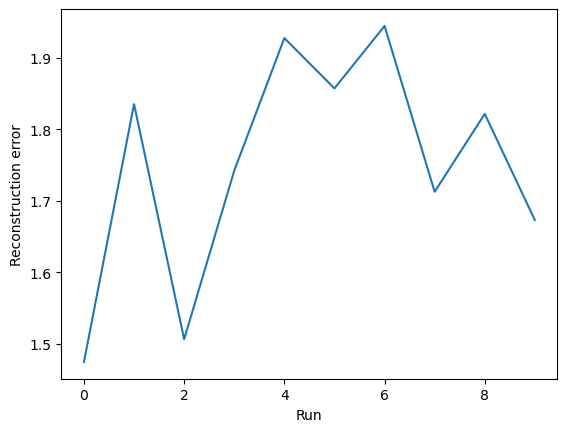

In [401]:
n_runs = 10
reconstruction_errors = np.zeros(n_runs)

for i in range(n_runs):
    # create random projection model
    rp = GaussianRandomProjection(n_components = 5)

    # fit random projection to data
    rp.fit(salaries_X)

    # transform data into random projection space
    X_rp = rp.transform(salaries_X)

    # inverse transform random projection space to original space
    X_rp_inv = np.linalg.pinv(rp.components_).dot(X_rp.T).T

    # calculate reconstruction error
    reconstruction_errors[i] = np.mean(np.linalg.norm(salaries_X - X_rp_inv, axis=1))

plt.plot(reconstruction_errors)
plt.xlabel('Run')
plt.ylabel('Reconstruction error')
plt.show()

In [428]:
salaries_variances = np.var(salaries_X, axis=0)
salaries_stddevs = np.std(salaries_X, axis=0)

mean_error = np.mean(reconstruction_errors)
stddev_error = np.std(reconstruction_errors)

print(np.mean(salaries_stddevs))
print(stddev_error)
# Compare the standard deviation of the reconstruction errors to the standard deviation of the data
if stddev_error > np.mean(salaries_stddevs):
    print("The variation in the randomized projection is relatively high compared to the variation in the data.")
else:
    print("The variation in the randomized projection is relatively low compared to the variation in the data.")


0.2155278623062034
0.15858106823710172
The variation in the randomized projection is relatively low compared to the variation in the data.


In [261]:
#reduced dimensions

salaries_transformed_X_train = salaries_transformed_X[:len(salaries_X_train)]
salaries_transformed_X_test = salaries_transformed_X[len(salaries_X_train):]

salaries_ica_X_train = salaries_ica_X[:len(salaries_X_train)]
salaries_ica_X_test = salaries_ica_X[len(salaries_X_train):]

salaries_rp_X_train = salaries_rp_X[:len(salaries_X_train)]
salaries_rp_X_test = salaries_rp_X[len(salaries_X_train):]

salaries_fs_X_train = salaries_fs_X[:len(salaries_X_train)]
salaries_fs_X_test = salaries_fs_X[len(salaries_X_train):]



# K-means cluster labels
salaries_X_kmeans_train = salaries_X_kmeans[:len(salaries_X_train)]
salaries_X_kmeans_test = salaries_X_kmeans[len(salaries_X_train):]

salaries_transformed_X_kmeans_train = salaries_transformed_X_kmeans[:len(salaries_X_train)]
salaries_transformed_X_kmeans_test = salaries_transformed_X_kmeans[len(salaries_X_train):]

salaries_ica_X_kmeans_train = salaries_ica_X_kmeans[:len(salaries_X_train)]
salaries_ica_X_kmeans_test = salaries_ica_X_kmeans[len(salaries_X_train):]

salaries_rp_X_kmeans_train = salaries_rp_X_kmeans[:len(salaries_X_train)]
salaries_rp_X_kmeans_test = salaries_rp_X_kmeans[len(salaries_X_train):]

salaries_fs_X_kmeans_train = salaries_fs_X_kmeans[:len(salaries_X_train)]
salaries_fs_X_kmeans_test = salaries_fs_X_kmeans[len(salaries_X_train):]

# EM cluster labels
salaries_X_em_train = salaries_X_em[:len(salaries_X_train)]
salaries_X_em_test = salaries_X_em[len(salaries_X_train):]

salaries_transformed_X_em_train = salaries_transformed_X_em[:len(salaries_X_train)]
salaries_transformed_X_em_test = salaries_transformed_X_em[len(salaries_X_train):]

salaries_ica_X_em_train = salaries_ica_X_em[:len(salaries_X_train)]
salaries_ica_X_em_test = salaries_ica_X_em[len(salaries_X_train):]

salaries_rp_X_em_train = salaries_rp_X_em[:len(salaries_X_train)]
salaries_rp_X_em_test = salaries_rp_X_em[len(salaries_X_train):]

salaries_fs_X_em_train = salaries_fs_X_em[:len(salaries_X_train)]
salaries_fs_X_em_test = salaries_fs_X_em[len(salaries_X_train):]



In [376]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import numpy as np
import time

from sklearn.model_selection import learning_curve

# Define the function to plot the learning curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("F1 weighted score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_weighted')

    # Calculate the mean and standard deviation of the training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the training and test scores
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange",
             label="Cross-validation score")
    plt.title('title')
    plt.legend(loc="best")
    plt.show()

# Define activation function and parameters
activation = 'relu'
learning_rate = 0.0001
hidden_nodes = [200]

# Create a list of tuples containing the training and testing sets
datasets = [(salaries_X_train, salaries_X_test),
            (salaries_transformed_X_train, salaries_transformed_X_test),
            (salaries_ica_X_train, salaries_ica_X_test),
            (salaries_rp_X_train, salaries_rp_X_test),
            (salaries_fs_X_train, salaries_fs_X_test),
            (salaries_X_kmeans_train, salaries_X_kmeans_test),
            (salaries_transformed_X_kmeans_train, salaries_transformed_X_kmeans_test),
            (salaries_ica_X_kmeans_train, salaries_ica_X_kmeans_test),
            (salaries_rp_X_kmeans_train, salaries_rp_X_kmeans_test),
            (salaries_fs_X_kmeans_train, salaries_fs_X_kmeans_test),
            (salaries_X_em_train, salaries_X_em_test),
            (salaries_transformed_X_em_train, salaries_transformed_X_em_test),
            (salaries_ica_X_em_train, salaries_ica_X_em_test),
            (salaries_rp_X_em_train, salaries_rp_X_em_test),
            (salaries_fs_X_em_train, salaries_fs_X_em_test)]

# Define the neural network model and train on each dataset
nn_models = []
nn_models_output = []
nn_model_training_time = []
nn_model_prediction_time = []
dim_reduction_method = ['unstransformed', 'pca', 'ica', 'rp', 'fs', 'unstransformed', 'pca', 'ica', 'rp', 'fs','unstransformed', 'pca', 'ica', 'rp', 'fs' ]
clustering_method = ['unclustered']*5 + ['kmeans']*5 + ['em']*5
plot_title_names = [dim_reduction_method[i] + '_' + clustering_method[i] for i in range(len(dim_reduction_method))]
for i in range(len(datasets)):
    X_train = datasets[i][0]
    X_test = datasets[i][1]
    y_train = salaries_y_train
    title = plot_title_names[i]
    nn_model = mlrose.NeuralNetwork(hidden_nodes=hidden_nodes, activation=activation, 
                                    algorithm='gradient_descent', max_iters=1000, 
                                    bias=True, is_classifier=True, learning_rate=learning_rate, 
                                    early_stopping=True, clip_max=5, max_attempts=100, 
                                    random_state=42)
#     nn_model_for_lc = mlrose.NeuralNetwork(hidden_nodes=hidden_nodes, activation=activation, 
#                                     algorithm='gradient_descent', max_iters=1000, 
#                                     bias=True, is_classifier=True, learning_rate=learning_rate, 
#                                     early_stopping=True, clip_max=5, max_attempts=100, 
#                                     random_state=42)
    
#     print(f'plotting lc for: {title}')
#     plot_learning_curve(nn_model_for_lc, title, X_train, y_train, cv= 5, train_sizes=np.linspace(.1, 1.0, 5))
    
    start_time = time.time()
    #print(f'fitting for: {title}')
    nn_model.fit(X_train, salaries_y_train)
    nn_models.append(nn_model)
    nn_model_training_time.append(time.time() - start_time)
    start_time = time.time()
    #print(f'predict for: {title}')
    y_pred = nn_model.predict(X_test)
    nn_models_output.append(y_pred)
    nn_model_prediction_time.append(time.time() - start_time)


In [377]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# initialize a list to store the results
results = []

# loop through each of the nn_models
for i, y_pred in enumerate(nn_models_output):
    
    # calculate the metrics
    accuracy = accuracy_score(salaries_y_test, y_pred)
#     precision = precision_score(salaries_y_test, y_pred)
#     recall = recall_score(salaries_y_test, y_pred)
    f1_weighted_score = f1_score(salaries_y_test, y_pred, average='weighted')
        
    # add the results to the list
    results.append({'Method': i+1, 'Accuracy': accuracy, 'F1_weighted_score': f1_weighted_score})
    
# create a dataframe from the results
salaries_results_df = pd.DataFrame(results)
dim_reduction_method = ['unstransformed', 'pca', 'ica', 'rp', 'fs', 'unstransformed', 'pca', 'ica', 'rp', 'fs','unstransformed', 'pca', 'ica', 'rp', 'fs' ]
clustering_method = ['unclustered']*5 + ['kmeans']*5 + ['em']*5
salaries_results_df['dimensionality_reduction_method'] = dim_reduction_method
salaries_results_df['clustering_method'] = clustering_method
salaries_results_df['training_time'] = nn_model_training_time
salaries_results_df['prediction_time'] = nn_model_prediction_time

In [378]:
salaries_results_df['dataset_name'] = plot_title_names
salaries_results_df

,Method,Accuracy,F1_weighted_score,dimensionality_reduction_method,clustering_method,training_time,prediction_time,dataset_name
0,1,0.825153,0.828506,unstransformed,unclustered,12.817948,0.003474,unstransformed_unclustered
1,2,0.766871,0.756553,pca,unclustered,11.171475,0.001232,pca_unclustered
2,3,0.769939,0.669860,ica,unclustered,9.614607,0.002306,ica_unclustered
3,4,0.785276,0.777137,rp,unclustered,11.965821,0.002903,rp_unclustered
4,5,0.819018,0.813798,fs,unclustered,11.246011,0.002965,fs_unclustered
5,6,0.800613,0.805191,unstransformed,kmeans,13.059869,0.004409,unstransformed_kmeans
6,7,0.776074,0.765430,pca,kmeans,12.218982,0.004184,pca_kmeans
7,8,0.742331,0.753633,ica,kmeans,10.785903,0.000899,ica_kmeans
8,9,0.779141,0.770770,rp,kmeans,12.260790,0.002066,rp_kmeans
9,10,0.812883,0.808559,fs,kmeans,11.941589,0.000904,fs_kmeans


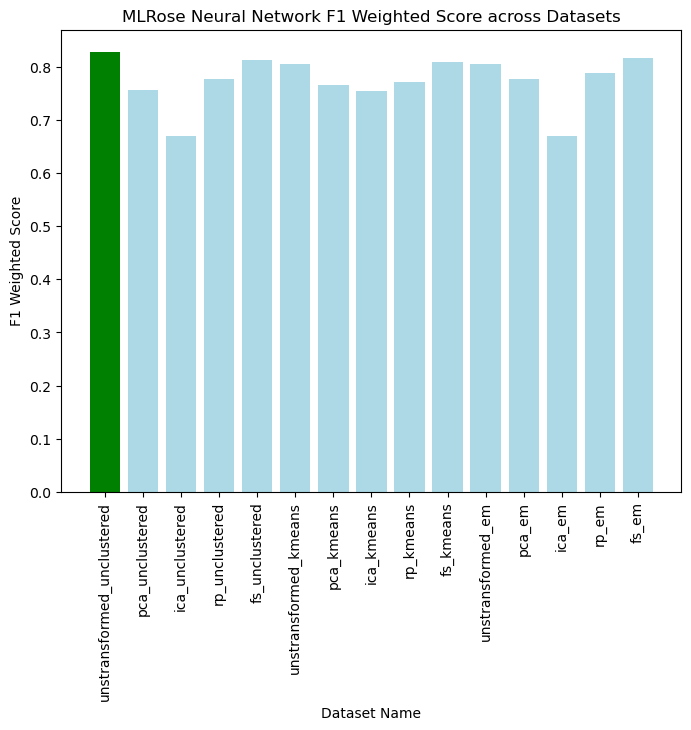

In [379]:
fig, ax = plt.subplots(figsize=(8, 6))

# sort dataframe by descending f1_weighted_score and get top value
df_sorted = salaries_results_df.sort_values('F1_weighted_score', ascending=False)
top_score = df_sorted.iloc[0]['F1_weighted_score']

# create bar chart
ax.bar(salaries_results_df['dataset_name'], salaries_results_df['F1_weighted_score'], color='lightblue')

# highlight bar with top score
ax.bar(df_sorted.iloc[0]['dataset_name'], top_score, color='green')

# set title and axis labels
ax.set_title('MLRose Neural Network F1 Weighted Score across Datasets')
ax.set_xlabel('Dataset Name')
ax.set_ylabel('F1 Weighted Score')

# rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# display plot
plt.show()

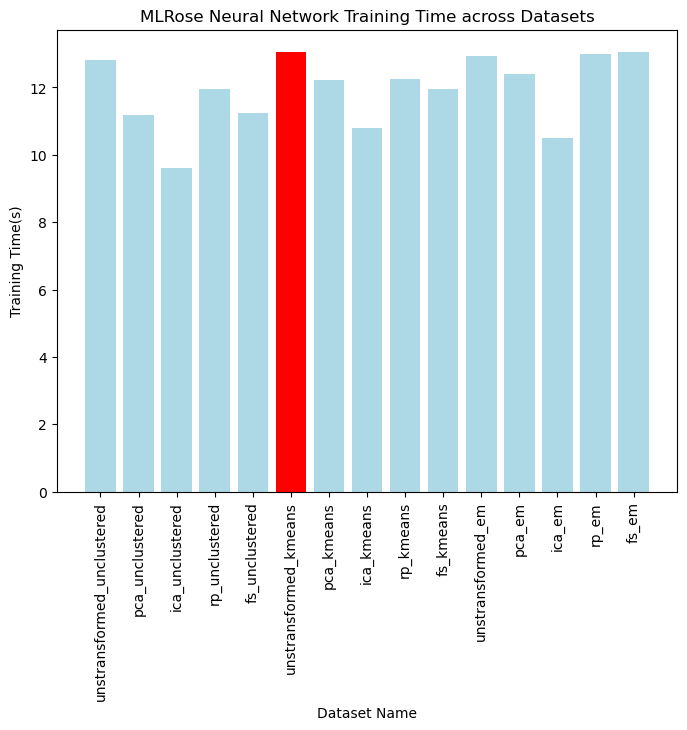

In [380]:
fig, ax = plt.subplots(figsize=(8, 6))

# sort dataframe by descending f1_weighted_score and get top value
df_sorted = salaries_results_df.sort_values('training_time', ascending=False)
top_score = df_sorted.iloc[0]['training_time']

# create bar chart
ax.bar(salaries_results_df['dataset_name'], salaries_results_df['training_time'], color='lightblue')

# highlight bar with top score
ax.bar(df_sorted.iloc[0]['dataset_name'], top_score, color='red')

# set title and axis labels
ax.set_title('MLRose Neural Network Training Time across Datasets')
ax.set_xlabel('Dataset Name')
ax.set_ylabel('Training Time(s)')

# rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# display plot
plt.show()

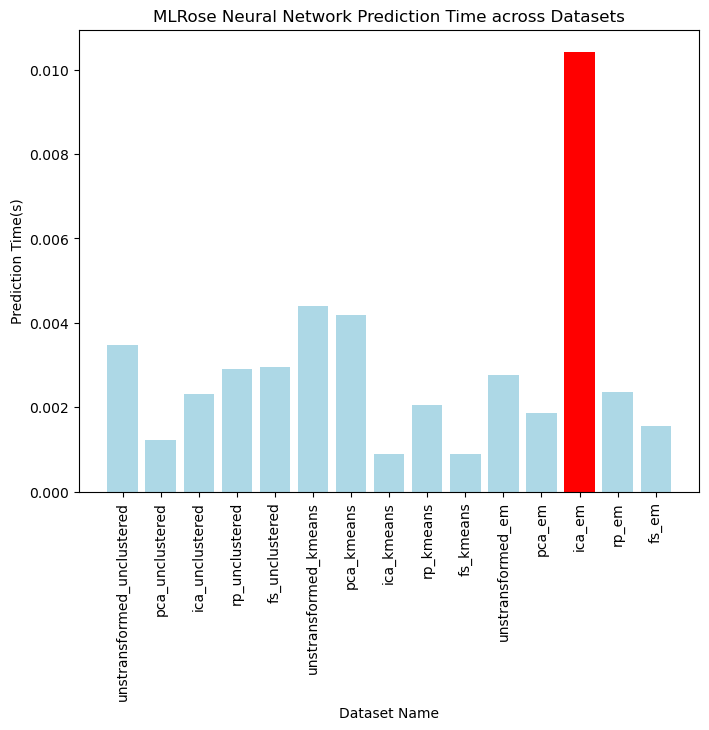

In [381]:
fig, ax = plt.subplots(figsize=(8, 6))

# sort dataframe by descending f1_weighted_score and get top value
df_sorted = salaries_results_df.sort_values('prediction_time', ascending=False)
top_score = df_sorted.iloc[0]['prediction_time']

# create bar chart
ax.bar(salaries_results_df['dataset_name'], salaries_results_df['prediction_time'], color='lightblue')

# highlight bar with top score
ax.bar(df_sorted.iloc[0]['dataset_name'], top_score, color='red')

# set title and axis labels
ax.set_title('MLRose Neural Network Prediction Time across Datasets')
ax.set_xlabel('Dataset Name')
ax.set_ylabel('Prediction Time(s)')

# rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# display plot
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [614, 1302]

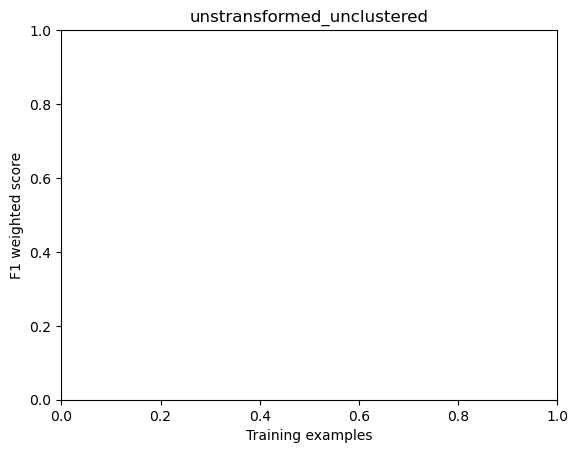

In [365]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Define the function to plot the learning curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("F1 weighted score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_weighted')

    # Calculate the mean and standard deviation of the training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the training and test scores
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.title('title')
    plt.legend(loc="best")
    return plt

nn_model = mlrose.NeuralNetwork(hidden_nodes=100, activation=activation, 
                                    algorithm='gradient_descent', max_iters=1000, 
                                    bias=True, is_classifier=True, learning_rate=learning_rate, 
                                    early_stopping=True, clip_max=5, max_attempts=100, 
                                    random_state=42)


for i in range(len(datasets)):
    X = datasets[i][0]
    y = salaries_y_train
    t = list(salaries_results_df['dataset_name'])[i]
    plot_learning_curve(nn_model, t, X, y, cv=5, train_sizes=np.linspace(.1, 1.0, 5))

In [312]:
salaries_transformed_X_train.shape

(1302, 5)

5.Diabetes

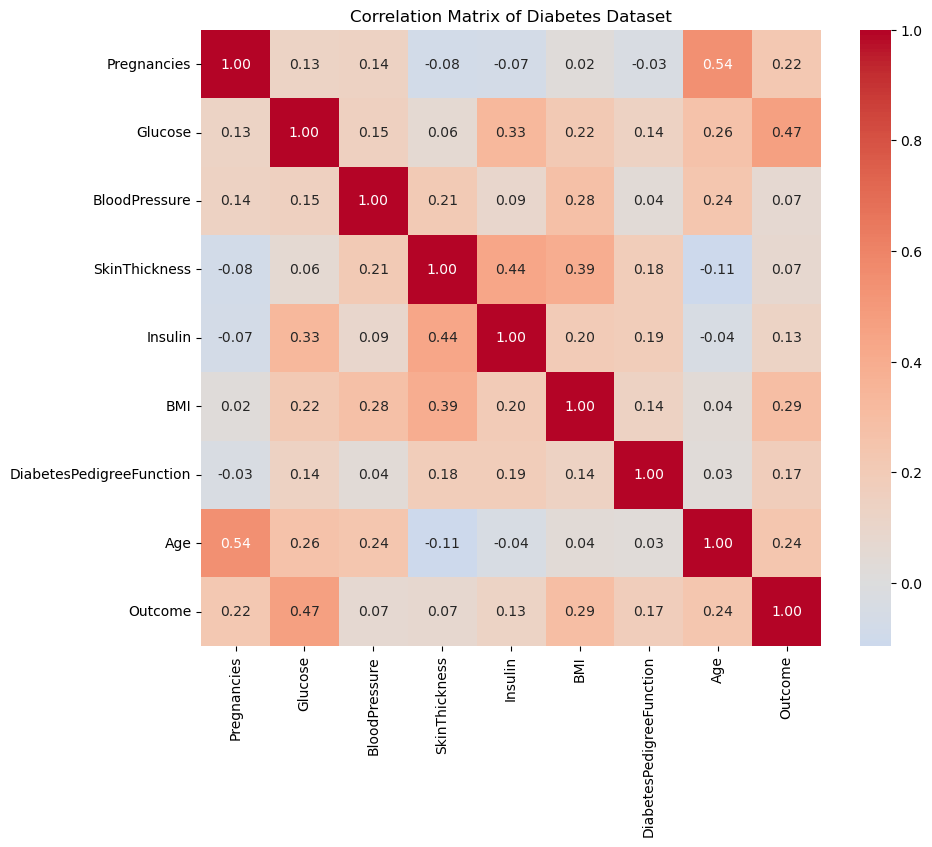

In [208]:
corr = diabetes.corr()

# plot the correlation matrix using seaborn
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=True, fmt='.2f')

ax.set_title('Correlation Matrix of Diabetes Dataset')

# show the plot
plt.show()

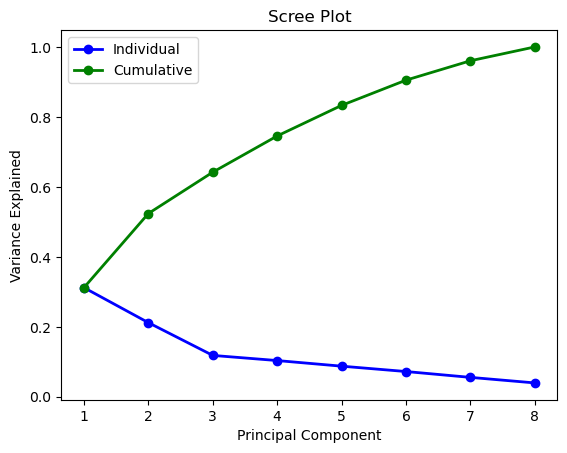

In [173]:
diabetes_pca, diabetes_pca_X = pca(diabetes_X, diabetes_X.shape[1])
scree_plot_pca(diabetes_pca)

In [209]:
stat, p = shapiro(diabetes_X)
print(f'shapiro p value:{p}')
if p > 0.05:
    print('Data is normally distributed')
else:
    print('Data is not normally distributed')

shapiro p value:9.80908925027372e-45
Data is not normally distributed


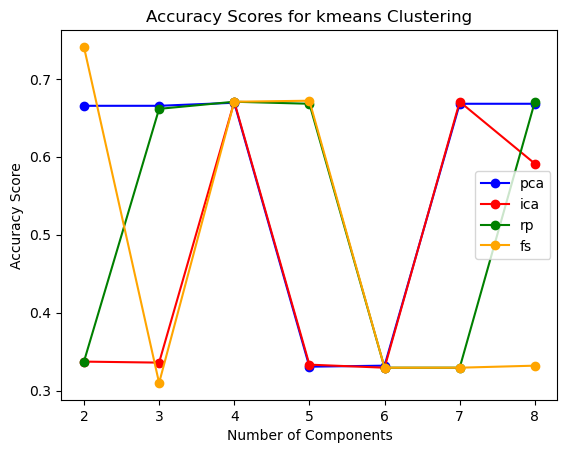

(2, 2, 2, 0)

In [175]:
#plot_accuracy_scores(diabetes_X, diabetes_y, diabetes_y, ctype = 'kmeans')

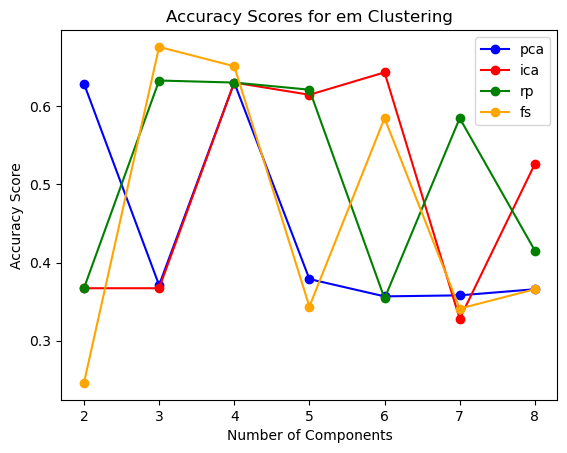

(2, 4, 1, 1)

In [176]:
#plot_accuracy_scores(diabetes_X, diabetes_y, diabetes_y, ctype = 'em')

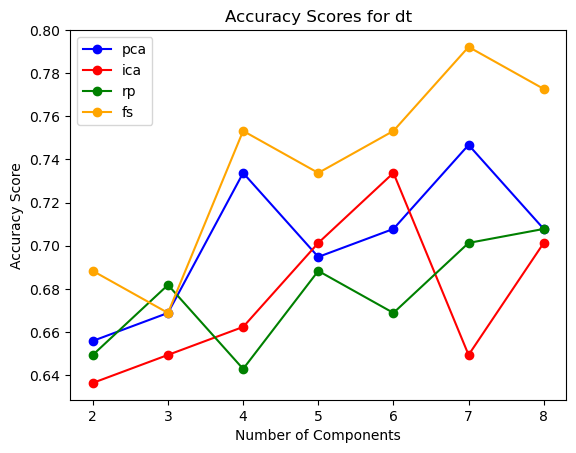

(5, 4, 6, 5)

In [269]:
plot_accuracy_scores(diabetes_X_train, diabetes_y_train, diabetes_X_test, diabetes_y_test, ctype = 'dt')

In [270]:
diabetes_optimal_n_pca,diabetes_optimal_n_ica,diabetes_optimal_n_rp,diabetes_optimal_n_fs = 4, 6, 2, 4
diabetes_pca, diabetes_transformed_X = pca(diabetes_X, diabetes_optimal_n_pca)
diabetes_ica_X = ica(diabetes_X, diabetes_optimal_n_ica)
diabetes_rp_X = randomized_projection(diabetes_X, diabetes_optimal_n_rp)
diabetes_fs_X = feature_selection(diabetes_X, diabetes_y, diabetes_optimal_n_fs)

diabetes_data_mapping = {'untransformed': diabetes_X, 'pca': diabetes_transformed_X, 'ica': diabetes_ica_X, 'rp': diabetes_rp_X, 'fs':diabetes_fs_X }

Clustering untransformed data...


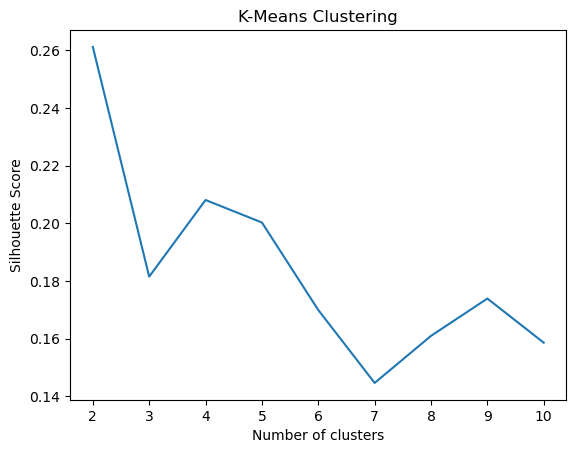

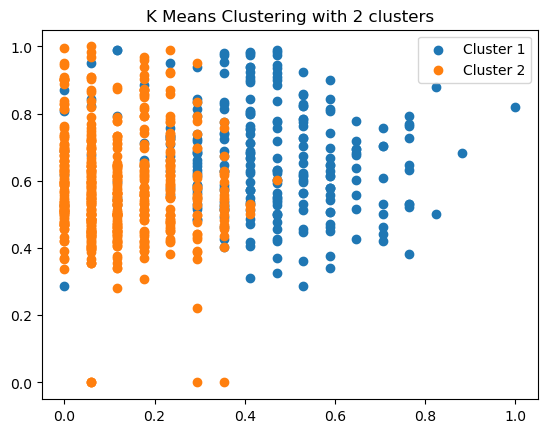

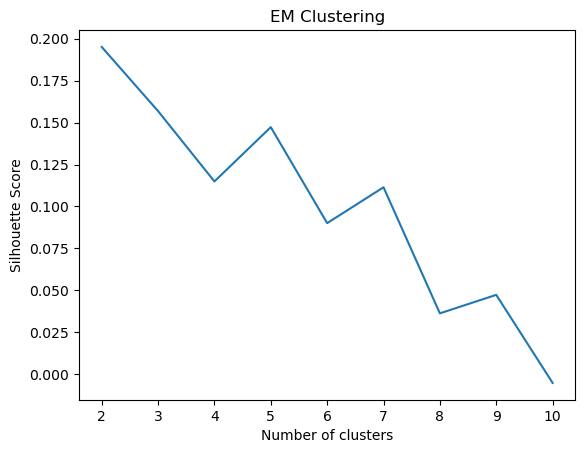

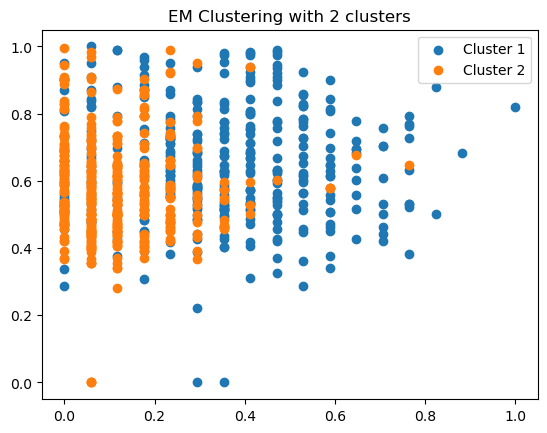

Clustering pca data...


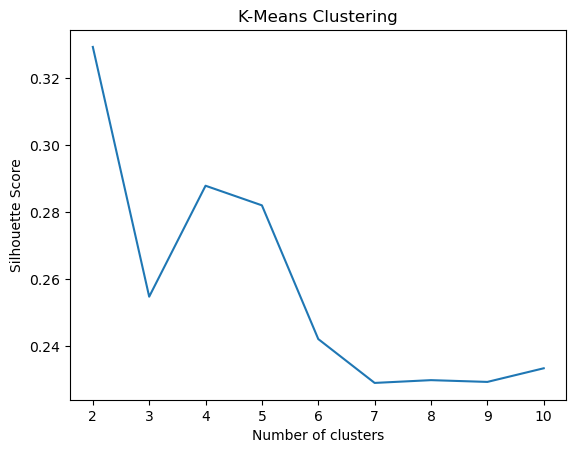

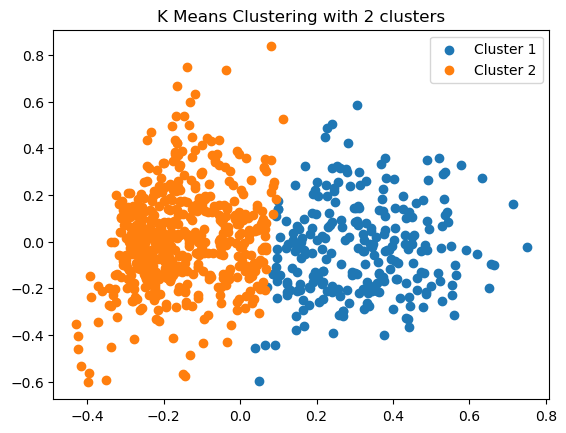

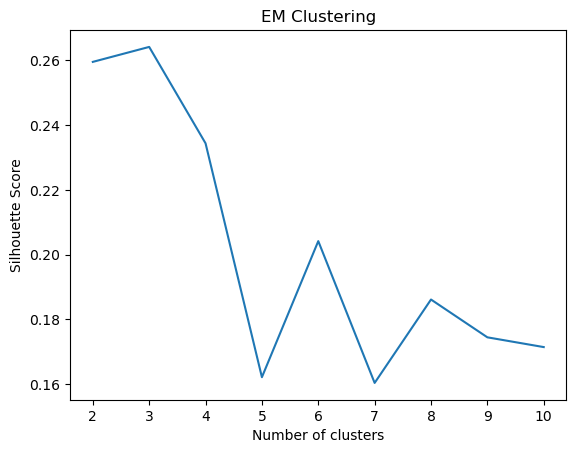

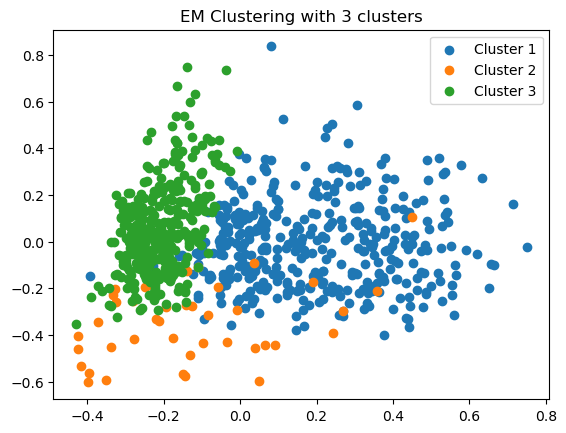

Clustering ica data...


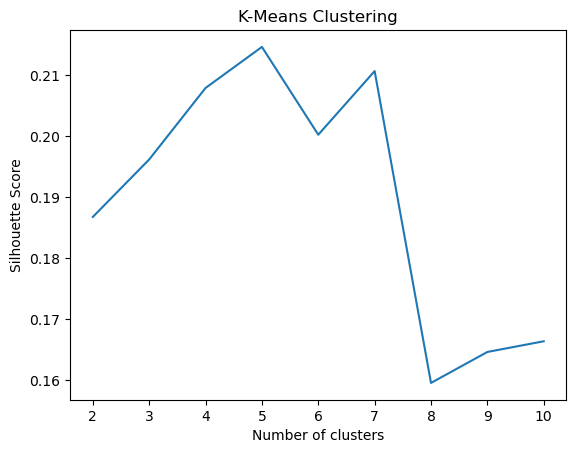

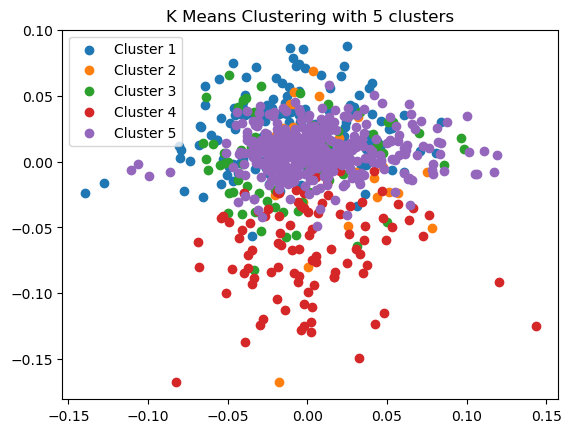

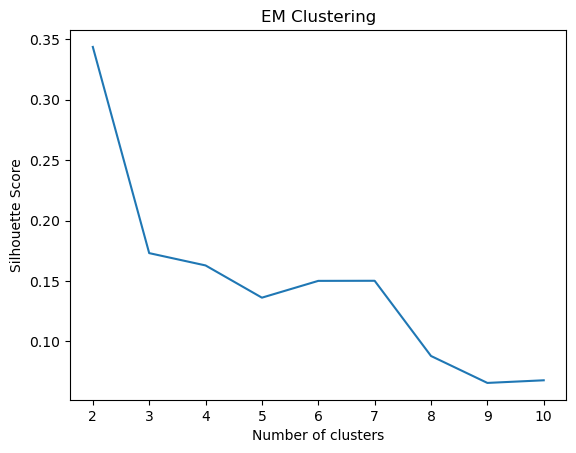

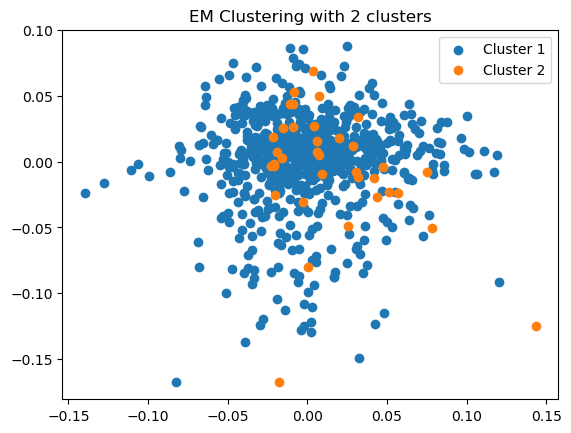

Clustering rp data...


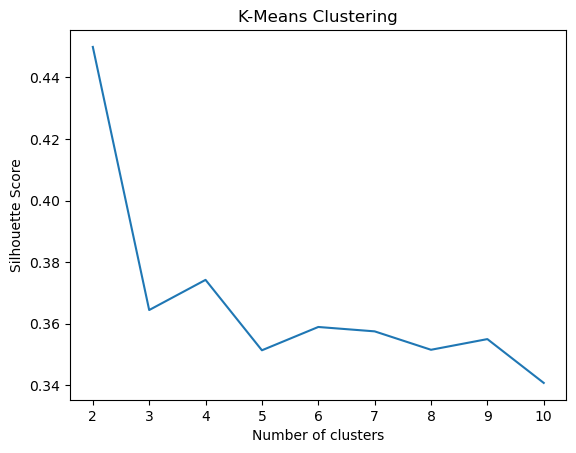

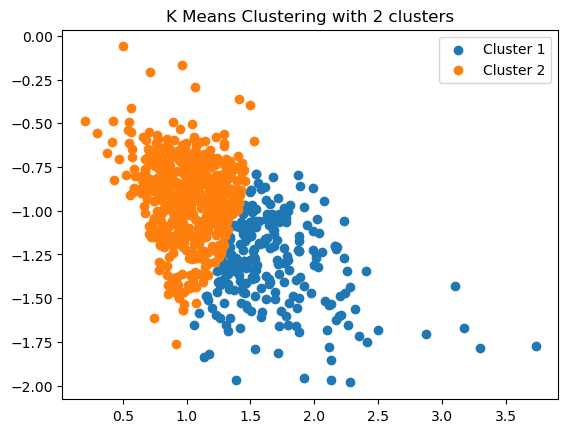

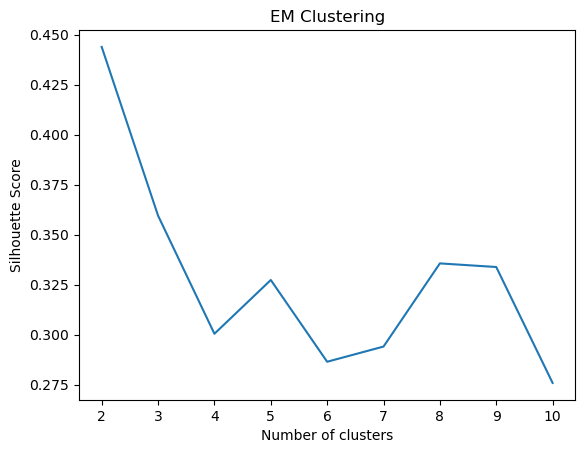

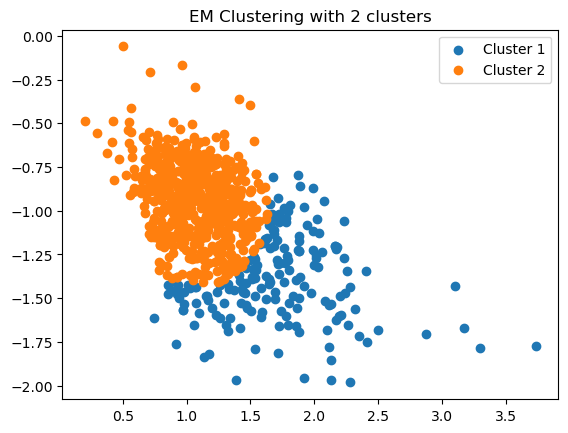

Clustering fs data...


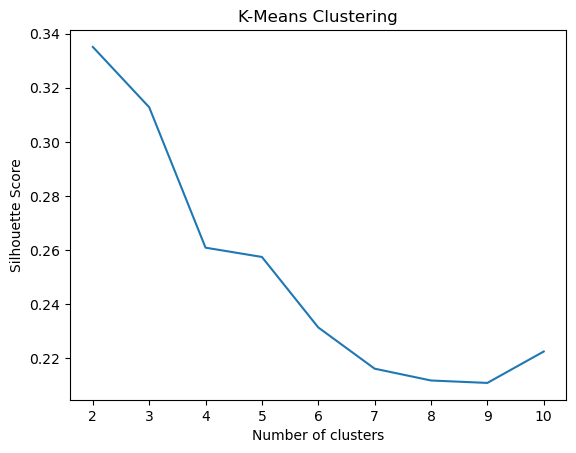

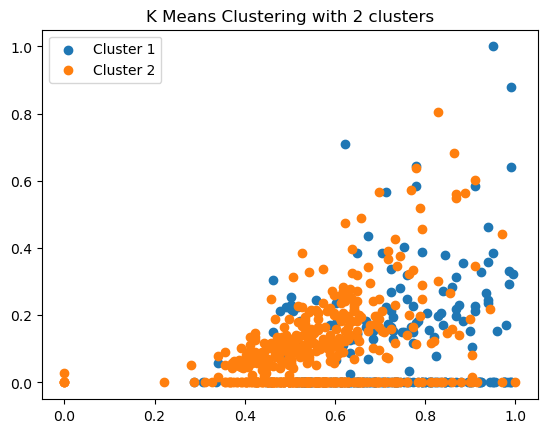

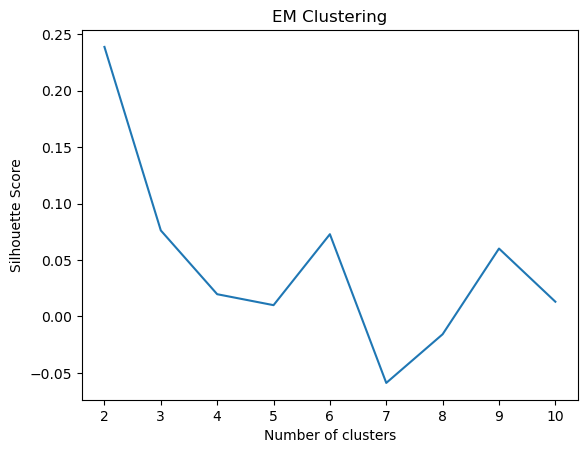

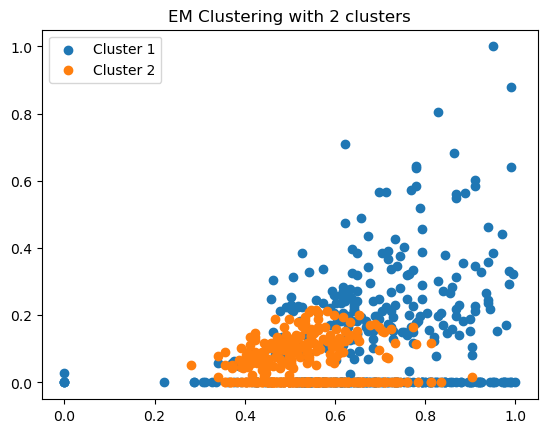

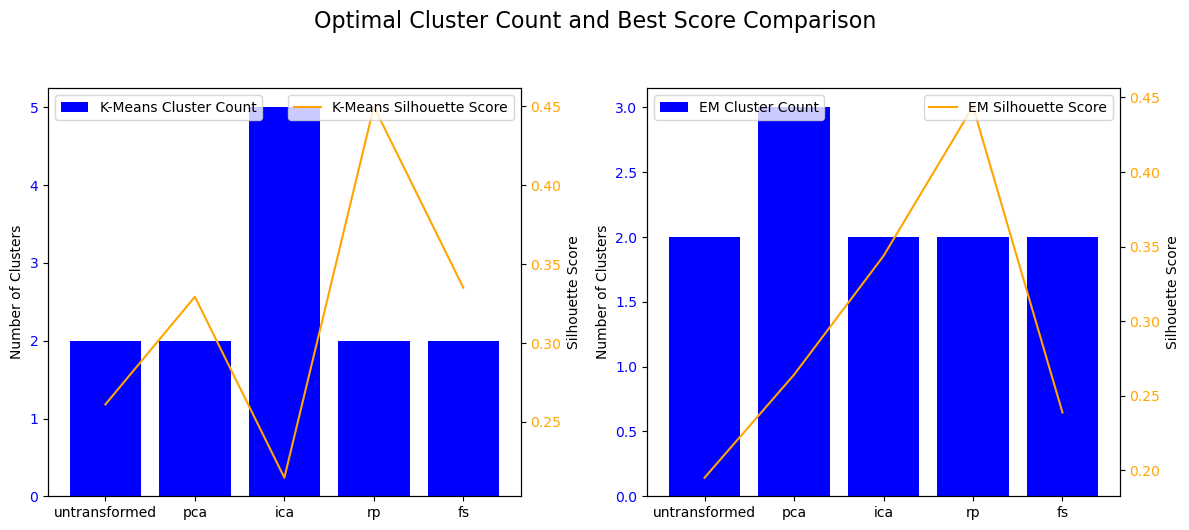

In [299]:
cluster_results = {}
for name, data in diabetes_data_mapping.items():
    print(f'Clustering {name} data...')
    kmeans_k, kmeans_score = plot_kmeans_clustering(data)
    em_k, em_score = plot_em_clustering(data)
    cluster_results[name] = {'kmeans_k': kmeans_k, 'kmeans_score': kmeans_score, 'em_k': em_k, 'em_score': em_score}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

x_labels = list(diabetes_data_mapping.keys())
kmeans_ks = [cluster_results[name]['kmeans_k'] for name in x_labels]
kmeans_scores = [cluster_results[name]['kmeans_score'] for name in x_labels]
ax1.bar(x_labels, kmeans_ks, label='K-Means Cluster Count', color='blue')
ax1.set_ylabel('Number of Clusters')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

ax1_scores = ax1.twinx()
ax1_scores.plot(x_labels, kmeans_scores, label='K-Means Silhouette Score', color='orange')
ax1_scores.set_ylabel('Silhouette Score')
ax1_scores.tick_params(axis='y', labelcolor='orange')
ax1_scores.legend(loc='upper right')

em_ks = [cluster_results[name]['em_k'] for name in x_labels]
em_scores = [cluster_results[name]['em_score'] for name in x_labels]
ax2.bar(x_labels, em_ks, label='EM Cluster Count', color='blue')
ax2.set_ylabel('Number of Clusters')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc='upper left')

ax2_scores = ax2.twinx()
ax2_scores.plot(x_labels, em_scores, label='EM Silhouette Score', color='orange')
ax2_scores.set_ylabel('Silhouette Score')
ax2_scores.tick_params(axis='y', labelcolor='orange')
ax2_scores.legend(loc='upper right')

plt.suptitle('Optimal Cluster Count and Best Score Comparison', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


In [272]:
# diabetes_transformed_X
# diabetes_ica
# diabetes_randomized_projection 
# diabetes_feature_selection 

#kmeans
kmeans_cluster_label = kmeans_clustering(diabetes_X,2)
pca_kmeans_cluster_label = kmeans_clustering(diabetes_transformed_X,2)
ica_kmeans_cluster_label = kmeans_clustering(diabetes_ica_X,5)
rp_kmeans_cluster_label = kmeans_clustering(diabetes_rp_X,2)
fs_kmeans_cluster_label = kmeans_clustering(diabetes_fs_X,2)

diabetes_X_kmeans = np.column_stack((diabetes_X, kmeans_cluster_label))
diabetes_transformed_X_kmeans = np.column_stack((diabetes_transformed_X, pca_kmeans_cluster_label))
diabetes_ica_X_kmeans = np.column_stack((diabetes_ica_X, ica_kmeans_cluster_label))
diabetes_rp_X_kmeans = np.column_stack((diabetes_rp_X, rp_kmeans_cluster_label))
diabetes_fs_X_kmeans = np.column_stack((diabetes_fs_X, fs_kmeans_cluster_label))


#em
em_cluster_label = em_clustering(diabetes_X,2)
pca_em_cluster_label = em_clustering(diabetes_transformed_X,3)
ica_em_cluster_label = em_clustering(diabetes_ica_X,2)
rp_em_cluster_label = em_clustering(diabetes_rp_X,2)
fs_em_cluster_label = em_clustering(diabetes_fs_X,2)


diabetes_X_em = np.column_stack((diabetes_X, em_cluster_label))
diabetes_transformed_X_em = np.column_stack((diabetes_transformed_X, pca_em_cluster_label))
diabetes_ica_X_em = np.column_stack((diabetes_ica_X, ica_em_cluster_label))
diabetes_rp_X_em = np.column_stack((diabetes_rp_X, rp_em_cluster_label))
diabetes_fs_X_em = np.column_stack((diabetes_fs_X, fs_em_cluster_label))


#reduced dimensions

diabetes_transformed_X_train = diabetes_transformed_X[:len(diabetes_X_train)]
diabetes_transformed_X_test = diabetes_transformed_X[len(diabetes_X_train):]

diabetes_ica_X_train = diabetes_ica_X[:len(diabetes_X_train)]
diabetes_ica_X_test = diabetes_ica_X[len(diabetes_X_train):]

diabetes_rp_X_train = diabetes_rp_X[:len(diabetes_X_train)]
diabetes_rp_X_test = diabetes_rp_X[len(diabetes_X_train):]

diabetes_fs_X_train = diabetes_fs_X[:len(diabetes_X_train)]
diabetes_fs_X_test = diabetes_fs_X[len(diabetes_X_train):]



# K-means cluster labels
diabetes_X_kmeans_train = diabetes_X_kmeans[:len(diabetes_X_train)]
diabetes_X_kmeans_test = diabetes_X_kmeans[len(diabetes_X_train):]

diabetes_transformed_X_kmeans_train = diabetes_transformed_X_kmeans[:len(diabetes_X_train)]
diabetes_transformed_X_kmeans_test = diabetes_transformed_X_kmeans[len(diabetes_X_train):]

diabetes_ica_X_kmeans_train = diabetes_ica_X_kmeans[:len(diabetes_X_train)]
diabetes_ica_X_kmeans_test = diabetes_ica_X_kmeans[len(diabetes_X_train):]

diabetes_rp_X_kmeans_train = diabetes_rp_X_kmeans[:len(diabetes_X_train)]
diabetes_rp_X_kmeans_test = diabetes_rp_X_kmeans[len(diabetes_X_train):]

diabetes_fs_X_kmeans_train = diabetes_fs_X_kmeans[:len(diabetes_X_train)]
diabetes_fs_X_kmeans_test = diabetes_fs_X_kmeans[len(diabetes_X_train):]

# EM cluster labels
diabetes_X_em_train = diabetes_X_em[:len(diabetes_X_train)]
diabetes_X_em_test = diabetes_X_em[len(diabetes_X_train):]

diabetes_transformed_X_em_train = diabetes_transformed_X_em[:len(diabetes_X_train)]
diabetes_transformed_X_em_test = diabetes_transformed_X_em[len(diabetes_X_train):]

diabetes_ica_X_em_train = diabetes_ica_X_em[:len(diabetes_X_train)]
diabetes_ica_X_em_test = diabetes_ica_X_em[len(diabetes_X_train):]

diabetes_rp_X_em_train = diabetes_rp_X_em[:len(diabetes_X_train)]
diabetes_rp_X_em_test = diabetes_rp_X_em[len(diabetes_X_train):]

diabetes_fs_X_em_train = diabetes_fs_X_em[:len(diabetes_X_train)]
diabetes_fs_X_em_test = diabetes_fs_X_em[len(diabetes_X_train):]


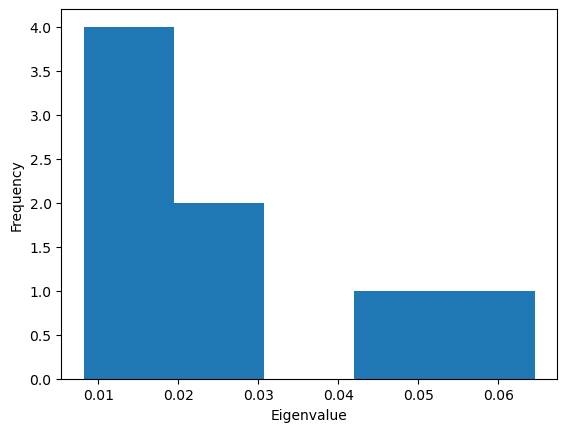

In [418]:
pca = PCA()

# fit PCA to data
pca.fit(diabetes_X)

# get eigenvalues (variances explained by each component)
eigenvalues = pca.explained_variance_

# plot distribution of eigenvalues
plt.hist(eigenvalues, bins=5)
plt.xlabel('Eigenvalue')
plt.ylabel('Frequency')
plt.show()

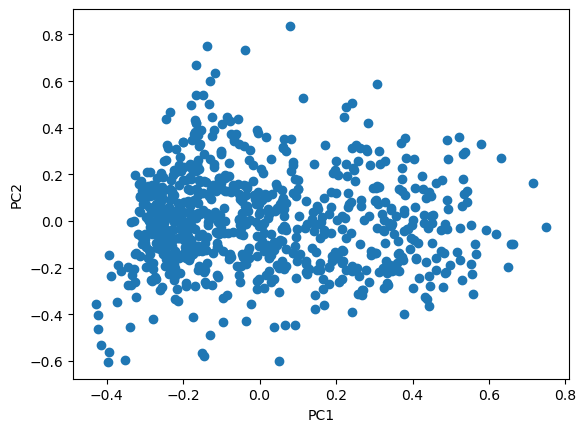

In [403]:
# plot the first two principal components
plt.scatter(diabetes_transformed_X[:, 0], diabetes_transformed_X[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

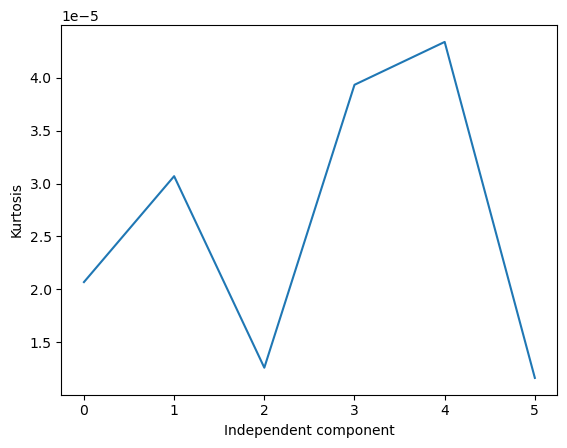

In [404]:
# calculate kurtosis of independent components
kurtosis = np.abs(np.asarray([np.mean((3 - 3 / (1 + x ** 4))) for x in diabetes_ica_X.T]))
# plot kurtosis of independent components
plt.plot(kurtosis)
plt.xlabel('Independent component')
plt.ylabel('Kurtosis')
plt.show()

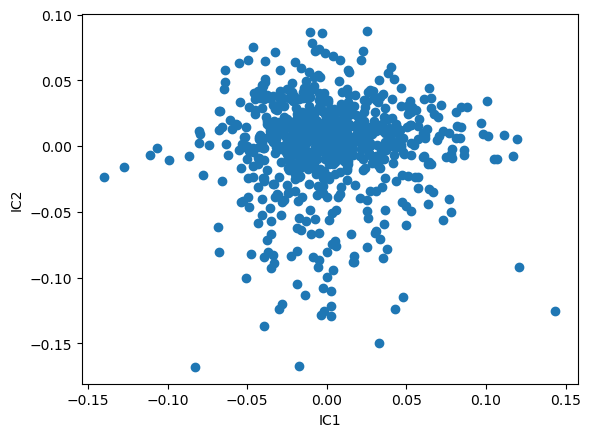

In [405]:
# transform data into independent component space
# plot the first two independent components
plt.scatter(diabetes_ica_X[:, 0], diabetes_ica_X[:, 1])
plt.xlabel('IC1')
plt.ylabel('IC2')
plt.show()


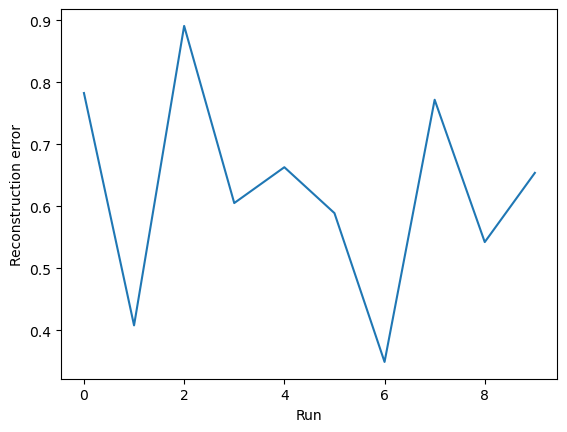

In [425]:
n_runs = 10
reconstruction_errors = np.zeros(n_runs)
random.seed(10)

for i in range(n_runs):
    # create random projection model
    rp = GaussianRandomProjection(n_components = 5)

    # fit random projection to data
    rp.fit(diabetes_X)

    # transform data into random projection space
    X_rp = rp.transform(diabetes_X)

    # inverse transform random projection space to original space
    X_rp_inv = np.linalg.pinv(rp.components_).dot(X_rp.T).T

    # calculate reconstruction error
    reconstruction_errors[i] = np.mean(np.linalg.norm(diabetes_X - X_rp_inv, axis=1))

plt.plot(reconstruction_errors)
plt.xlabel('Run')
plt.ylabel('Reconstruction error')
plt.show()

In [429]:
diabetes_variances = np.var(diabetes_X, axis=0)
diabetes_stddevs = np.std(diabetes_X, axis=0)

diabetes_mean_error = np.mean(reconstruction_errors)
diabetes_stddev_error = np.std(reconstruction_errors)

print(np.mean(diabetes_stddevs))
print(diabetes_stddev_error)

# Compare the standard deviation of the reconstruction errors to the standard deviation of the data
if stddev_error > np.mean(diabetes_stddevs):
    print("The variation in the randomized projection is relatively high compared to the variation in the data.")
else:
    print("The variation in the randomized projection is relatively low compared to the variation in the data.")


0.15862935131939818
0.15858106823710172
The variation in the randomized projection is relatively low compared to the variation in the data.


In [368]:
datasets = [(diabetes_X_train, diabetes_X_test),
            (diabetes_transformed_X_train, diabetes_transformed_X_test),
            (diabetes_ica_X_train, diabetes_ica_X_test),
            (diabetes_rp_X_train, diabetes_rp_X_test),
            (diabetes_fs_X_train, diabetes_fs_X_test),
            (diabetes_X_kmeans_train, diabetes_X_kmeans_test),
            (diabetes_transformed_X_kmeans_train, diabetes_transformed_X_kmeans_test),
            (diabetes_ica_X_kmeans_train, diabetes_ica_X_kmeans_test),
            (diabetes_rp_X_kmeans_train, diabetes_rp_X_kmeans_test),
            (diabetes_fs_X_kmeans_train, diabetes_fs_X_kmeans_test),
            (diabetes_X_em_train, diabetes_X_em_test),
            (diabetes_transformed_X_em_train, diabetes_transformed_X_em_test),
            (diabetes_ica_X_em_train, diabetes_ica_X_em_test),
            (diabetes_rp_X_em_train, diabetes_rp_X_em_test),
            (diabetes_fs_X_em_train, diabetes_fs_X_em_test)]

# Define the neural network model and train on each dataset
nn_models = []
nn_models_output = []
nn_model_training_time = []
nn_model_prediction_time = []
for X_train, X_test in datasets:
    nn_model = mlrose.NeuralNetwork(hidden_nodes=hidden_nodes, activation=activation, 
                                    algorithm='gradient_descent', max_iters=1000, 
                                    bias=True, is_classifier=True, learning_rate=learning_rate, 
                                    early_stopping=True, clip_max=5, max_attempts=100, 
                                    random_state=42)
    start_time = time.time()
    nn_model.fit(X_train, diabetes_y_train)
    nn_models.append(nn_model)
    nn_model_training_time.append(time.time() - start_time)
    start_time = time.time()
    y_pred = nn_model.predict(X_test)
    nn_models_output.append(y_pred)
    nn_model_prediction_time.append(time.time() - start_time)

In [369]:
# initialize a list to store the results
results = []

# loop through each of the nn_models
for i, y_pred in enumerate(nn_models_output):
    
    # calculate the metrics
    accuracy = accuracy_score(diabetes_y_test, y_pred)
#     precision = precision_score(diabetes_y_test, y_pred)
#     recall = recall_score(diabetes_y_test, y_pred)
    f1_weighted_score = f1_score(diabetes_y_test, y_pred, average='weighted')
        
    # add the results to the list
    results.append({'Method': i+1, 'Accuracy': accuracy, 'F1_weighted_score': f1_weighted_score})
    
# create a dataframe from the results
diabetes_results_df = pd.DataFrame(results)
dim_reduction_method = ['unstransformed', 'pca', 'ica', 'rp', 'fs', 'unstransformed', 'pca', 'ica', 'rp', 'fs','unstransformed', 'pca', 'ica', 'rp', 'fs' ]
clustering_method = ['unclustered']*5 + ['kmeans']*5 + ['em']*5
diabetes_results_df['dimensionality_reduction_method'] = dim_reduction_method
diabetes_results_df['clustering_method'] = clustering_method
diabetes_results_df['training_time'] = nn_model_training_time
diabetes_results_df['prediction_time'] = nn_model_prediction_time

In [370]:
diabetes_results_df['dataset_name'] = plot_title_names
diabetes_results_df

,Method,Accuracy,F1_weighted_score,dimensionality_reduction_method,clustering_method,training_time,prediction_time,dataset_name
0,1,0.818182,0.813001,unstransformed,unclustered,6.012113,0.003191,unstransformed_unclustered
1,2,0.759740,0.759007,pca,unclustered,5.819707,0.003571,pca_unclustered
2,3,0.805195,0.789683,ica,unclustered,4.967016,0.000585,ica_unclustered
3,4,0.759740,0.762934,rp,unclustered,4.984582,0.001149,rp_unclustered
4,5,0.805195,0.801210,fs,unclustered,5.472125,0.000596,fs_unclustered
5,6,0.824675,0.820399,unstransformed,kmeans,5.784605,0.001191,unstransformed_kmeans
6,7,0.772727,0.768938,pca,kmeans,5.224472,0.002730,pca_kmeans
7,8,0.759740,0.765816,ica,kmeans,5.292098,0.000533,ica_kmeans
8,9,0.753247,0.736521,rp,kmeans,5.174419,0.002389,rp_kmeans
9,10,0.792208,0.782520,fs,kmeans,5.358324,0.002198,fs_kmeans


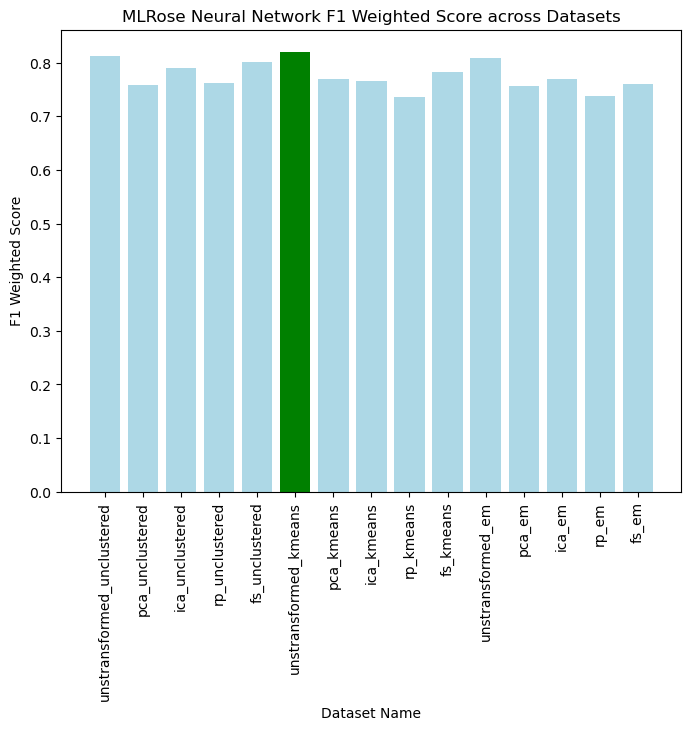

In [382]:
fig, ax = plt.subplots(figsize=(8, 6))

# sort dataframe by descending f1_weighted_score and get top value
df_sorted = diabetes_results_df.sort_values('F1_weighted_score', ascending=False)
top_score = df_sorted.iloc[0]['F1_weighted_score']

# create bar chart
ax.bar(diabetes_results_df['dataset_name'], diabetes_results_df['F1_weighted_score'], color='lightblue')

# highlight bar with top score
ax.bar(df_sorted.iloc[0]['dataset_name'], top_score, color='green')

# set title and axis labels
ax.set_title('MLRose Neural Network F1 Weighted Score across Datasets')
ax.set_xlabel('Dataset Name')
ax.set_ylabel('F1 Weighted Score')

# rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# display plot
plt.show()

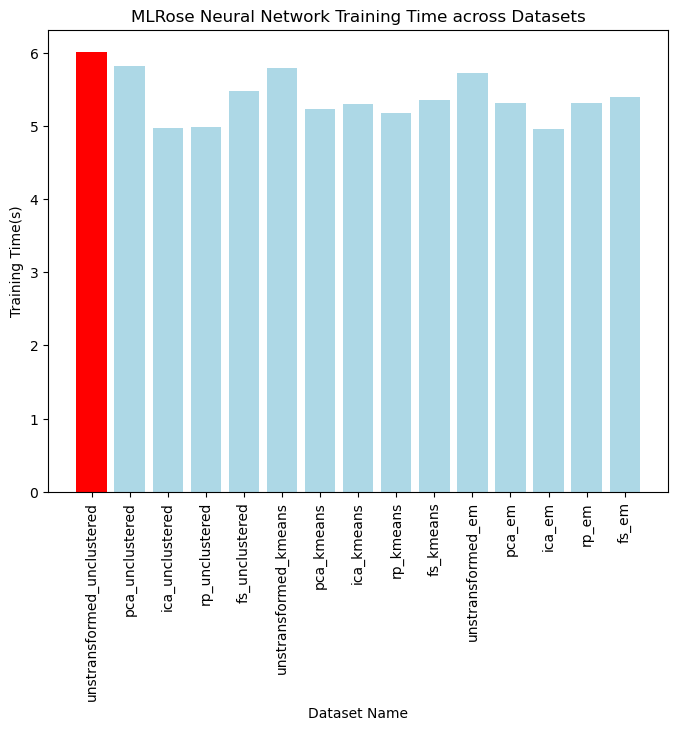

In [383]:
fig, ax = plt.subplots(figsize=(8, 6))

# sort dataframe by descending f1_weighted_score and get top value
df_sorted = diabetes_results_df.sort_values('training_time', ascending=False)
top_score = df_sorted.iloc[0]['training_time']

# create bar chart
ax.bar(diabetes_results_df['dataset_name'], diabetes_results_df['training_time'], color='lightblue')

# highlight bar with top score
ax.bar(df_sorted.iloc[0]['dataset_name'], top_score, color='red')

# set title and axis labels
ax.set_title('MLRose Neural Network Training Time across Datasets')
ax.set_xlabel('Dataset Name')
ax.set_ylabel('Training Time(s)')

# rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# display plot
plt.show()

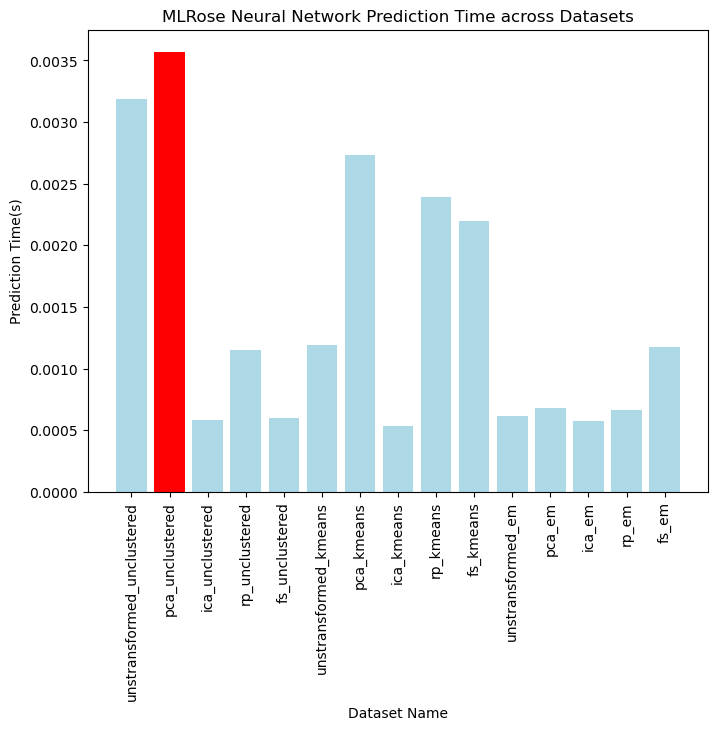

In [384]:
fig, ax = plt.subplots(figsize=(8, 6))

# sort dataframe by descending f1_weighted_score and get top value
df_sorted = diabetes_results_df.sort_values('prediction_time', ascending=False)
top_score = df_sorted.iloc[0]['prediction_time']

# create bar chart
ax.bar(diabetes_results_df['dataset_name'], diabetes_results_df['prediction_time'], color='lightblue')

# highlight bar with top score
ax.bar(df_sorted.iloc[0]['dataset_name'], top_score, color='red')

# set title and axis labels
ax.set_title('MLRose Neural Network Prediction Time across Datasets')
ax.set_xlabel('Dataset Name')
ax.set_ylabel('Prediction Time(s)')

# rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# display plot
plt.show()

In [ ]:
#salaries_X
#salaries_results_dict = {'data': salaries_X , 'pca': pca_salaries_X, 'ica':ica_salaries_X, 'rp': rp_salaries_X, 'fs': fs_salaries_X}

#scree plot and bic plot to get best n for dimensionality reduction
#initialize pca_data, ica_data, rp_data, fs_data with the best n
#loop through the different data types
#run run_clustering
#add accuracy and silhoutte score

In [ ]:
# def scree_plot(data, labels, max_n):
#     # Scree plot
#     pca_var_ratios, ica_var_ratios, rp_var_ratios, fs_var_ratios = [], [], [], []
#     for n in range(1, max_n+1):
#         pca_data, ica_data, rp_data, fs_data =  run_dimensionality_reduction(data, labels, n)
#         pca_var_ratio = pca_data.explained_variance_ratio_
#         ica_var_ratio = ica_data.explained_variance_ratio_
#         rp_var_ratio = rp_data.explained_variance_ratio_
#         fs_var_ratio = fs_data.explained_variance_ratio_
#         pca_var_ratios.append(pca_var_ratio)
#         ica_var_ratios.append(ica_var_ratio)
#         rp_var_ratios.append(rp_var_ratio)
#         fs_var_ratios.append(fs_var_ratio)

#     fig, axs = plt.subplots(2, 2, figsize=(10, 8))
#     axs[0, 0].plot(range(1, n+1), pca_var_ratios, 'b-o')
#     axs[0, 0].set_title('PCA Scree Plot')
#     axs[0, 1].plot(range(1, n+1), ica_var_ratios, 'g-o')
#     axs[0, 1].set_title('ICA Scree Plot')
#     axs[1, 0].plot(range(1, n+1), rp_var_ratios, 'r-o')
#     axs[1, 0].set_title('Randomized Projection Scree Plot')
#     axs[1, 1].plot(range(1, n+1), fs_var_ratios, 'm-o')
#     axs[1, 1].set_title('Feature Selection Scree Plot')
#     plt.tight_layout()
#     plt.show()
    
# def bic_plot(pca_data, ica_data, rp_data, fs_data):

#     # Bayesian information criterion (BIC)
#     k_range = range(1, n+1)
#     pca_bic = []
#     ica_bic = []
#     rp_bic = []
#     fs_bic = []

#     for k in k_range:
#         # Fit Gaussian mixture model to transformed data
#         pca_gmm = GaussianMixture(n_components=k, random_state=0).fit(pca_data)
#         ica_gmm = GaussianMixture(n_components=k, random_state=0).fit(ica_data)
#         rp_gmm = GaussianMixture(n_components=k, random_state=0).fit(rp_data)
#         fs_gmm = GaussianMixture(n_components=k, random_state=0).fit(fs_data)

#         # Calculate BIC score
#         pca_bic.append(pca_gmm.bic(pca_data))
#         ica_bic.append(ica_gmm.bic(ica_data))
#         rp_bic.append(rp_gmm.bic(rp_data))
#         fs_bic.append(fs_gmm.bic(fs_data))

#     # Plot BIC scores
#     fig, axs = plt.subplots(2, 2, figsize=(10, 8))
#     axs[0, 0].plot(k_range, pca_bic, 'b-o')
#     axs[0, 0].set_title('PCA BIC')
#     axs[0, 0].set_xlabel('Number of components')
#     axs[0, 0].set_ylabel('BIC Score')
#     axs[0, 1].plot(k_range, ica_bic, 'g-o')
#     axs[0, 1].set_title('ICA BIC')
#     axs[0, 1].set_xlabel('Number of components')
#     axs[0, 1].set_ylabel('BIC Score')
#     axs[1, 0].plot(k_range, rp_bic, 'r-o')
#     axs[1, 0].set_title('Randomized Projection BIC')
#     axs[1, 0].set_xlabel('Number of components')
#     axs[1, 0].set_ylabel('BIC Score')
#     axs[1, 1].plot(k_range, fs_bic, 'm-o')
#     axs[1, 1].set_title('Feature Selection BIC')
#     axs[1, 1].set_xlabel('Number of features')
#     axs[1, 1].set_ylabel('BIC Score')
#     plt.tight_layout()
#     plt.show()

#     # Find the optimal n for each dimensionality reduction algorithm based on the lowest BIC score
#     pca_optimal = k_range[np.argmin(pca_bic)]
#     ica_optimal = k_range[np.argmin(ica_bic)]
#     rp_optimal = k_range[np.argmin(rp_bic)]
#     fs_optimal = k_range[np.argmin(fs_bic)]

#     print("Optimal number of components for PCA: ", pca_optimal)
#     print("Optimal number of components for ICA: ", ica_optimal)
#     print("Optimal number of components for Randomized Projection: ", rp_optimal)
#     print("Optimal number of features for Feature Selection: ", fs_optimal)

#     #return pca_optimal, ica_optimal, rp_optimal, fs_optimal


